In [ ]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from math import sqrt
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

In [ ]:
#load the data
temp = pd.read_csv('Temperatura.csv', sep=';')
energy = pd.read_csv('Energia_Cieplna.csv', sep=';')
print(temp)
print(energy)

                      time  Katowice
0      2024-01-01 00:00:00       2.0
1      2024-01-01 01:00:00       1.5
2      2024-01-01 02:00:00       1.3
3      2024-01-01 03:00:00       0.8
4      2024-01-01 04:00:00       1.1
...                    ...       ...
10565  2025-03-16 05:00:00       0.9
10566  2025-03-16 06:00:00       0.8
10567  2025-03-16 07:00:00       0.9
10568  2025-03-16 08:00:00       1.6
10569  2025-03-16 09:00:00       2.7

[10570 rows x 2 columns]
                     Time  Produkcja energii ciep?a
0     2024-03-16 09:00:00                        26
1     2024-03-16 10:00:00                        26
2     2024-03-16 11:00:00                        26
3     2024-03-16 12:00:00                        25
4     2024-03-16 13:00:00                        25
...                   ...                       ...
8711  2025-03-16 03:00:00                        39
8712  2025-03-16 04:00:00                        39
8713  2025-03-16 05:00:00                        38
8714  2025

In [ ]:
#rename and standardize column names
temp = temp.rename(columns={'Katowice':'temp'})
energy = energy.rename(columns={energy.columns[0]:'time', energy.columns[1]: 'energy'})
print(temp)
print(energy)

                      time  temp
0      2024-01-01 00:00:00   2.0
1      2024-01-01 01:00:00   1.5
2      2024-01-01 02:00:00   1.3
3      2024-01-01 03:00:00   0.8
4      2024-01-01 04:00:00   1.1
...                    ...   ...
10565  2025-03-16 05:00:00   0.9
10566  2025-03-16 06:00:00   0.8
10567  2025-03-16 07:00:00   0.9
10568  2025-03-16 08:00:00   1.6
10569  2025-03-16 09:00:00   2.7

[10570 rows x 2 columns]
                     time  energy
0     2024-03-16 09:00:00      26
1     2024-03-16 10:00:00      26
2     2024-03-16 11:00:00      26
3     2024-03-16 12:00:00      25
4     2024-03-16 13:00:00      25
...                   ...     ...
8711  2025-03-16 03:00:00      39
8712  2025-03-16 04:00:00      39
8713  2025-03-16 05:00:00      38
8714  2025-03-16 06:00:00      35
8715  2025-03-16 07:00:00      37

[8716 rows x 2 columns]


In [ ]:
#merging datasets
data = temp.merge(energy, on='time', how='outer')
print(data)


                      time  temp  energy
0      2024-01-01 00:00:00   2.0     NaN
1      2024-01-01 01:00:00   1.5     NaN
2      2024-01-01 02:00:00   1.3     NaN
3      2024-01-01 03:00:00   0.8     NaN
4      2024-01-01 04:00:00   1.1     NaN
...                    ...   ...     ...
10567  2025-03-16 05:00:00   0.9    38.0
10568  2025-03-16 06:00:00   0.8    35.0
10569  2025-03-16 07:00:00   0.9    37.0
10570  2025-03-16 08:00:00   1.6     NaN
10571  2025-03-16 09:00:00   2.7     NaN

[10572 rows x 3 columns]


In [ ]:
#delete rows with no data
data.dropna(inplace=True)
print(data)

                      time  temp  energy
1809   2024-03-16 09:00:00   9.1    26.0
1810   2024-03-16 10:00:00  11.6    26.0
1811   2024-03-16 11:00:00  13.3    26.0
1812   2024-03-16 12:00:00  14.3    25.0
1813   2024-03-16 13:00:00  15.1    25.0
...                    ...   ...     ...
10565  2025-03-16 03:00:00   1.5    39.0
10566  2025-03-16 04:00:00   1.3    39.0
10567  2025-03-16 05:00:00   0.9    38.0
10568  2025-03-16 06:00:00   0.8    35.0
10569  2025-03-16 07:00:00   0.9    37.0

[8718 rows x 3 columns]


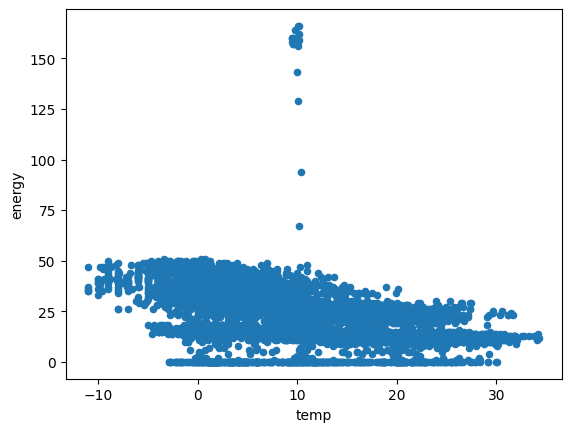

In [ ]:
#visual representation of the data
data.plot(kind="scatter", x="temp", y="energy")
df = data.copy(deep=True)

### Observations from the plot
Some energy consumption values are zero, which is likely due to measurement or recording errors.  
Additionally, the vertical "spike" at a certain temperature suggests that these high values may have been recorded simultaneously and should either be removed or standardized.

There are no unusual temperature readings detected across the dataset.

### Identifying anomalies
We sort the dataset by energy consumption in descending order to inspect potential outliers.  
Abnormally high values from October 4th and 5th are likely due to incorrect readings.

In [ ]:
# Data from October 4th and 5th show abnormally high values – likely incorrect measurements
data_sorted = data.sort_values(by=['energy'], ascending=False)
print(data_sorted.head(30))

                     time  temp  energy
6679  2024-10-05 08:00:00  10.1   166.0
6675  2024-10-05 04:00:00  10.2   166.0
6665  2024-10-04 18:00:00   9.8   164.0
6676  2024-10-05 05:00:00  10.2   162.0
6666  2024-10-04 19:00:00   9.6   160.0
6671  2024-10-05 00:00:00   9.5   160.0
6672  2024-10-05 01:00:00   9.8   160.0
6670  2024-10-04 23:00:00   9.5   160.0
6674  2024-10-05 03:00:00  10.2   159.0
6673  2024-10-05 02:00:00  10.0   159.0
6669  2024-10-04 22:00:00   9.5   158.0
6677  2024-10-05 06:00:00  10.1   158.0
6668  2024-10-04 21:00:00   9.6   157.0
6667  2024-10-04 20:00:00   9.6   157.0
6664  2024-10-04 17:00:00  10.1   156.0
6678  2024-10-05 07:00:00  10.0   143.0
6663  2024-10-04 16:00:00  10.1   129.0
6662  2024-10-04 15:00:00  10.4    94.0
6680  2024-10-05 09:00:00  10.2    67.0
8671  2024-12-27 05:00:00  -3.4    51.0
8851  2025-01-03 17:00:00   0.3    51.0
8847  2025-01-03 13:00:00   0.7    51.0
8842  2025-01-03 08:00:00  -0.5    50.0
8837  2025-01-03 03:00:00  -0.3    50.0


                     time  temp  energy
8847  2025-01-03 13:00:00   0.7    51.0
8851  2025-01-03 17:00:00   0.3    51.0
8671  2024-12-27 05:00:00  -3.4    51.0
9258  2025-01-20 16:00:00  -2.0    50.0
8856  2025-01-03 22:00:00   0.7    50.0
8857  2025-01-03 23:00:00   0.0    50.0
8862  2025-01-04 04:00:00  -4.7    50.0
8658  2024-12-26 16:00:00  -0.5    50.0
8872  2025-01-04 14:00:00  -2.1    50.0
8662  2024-12-26 20:00:00  -2.8    50.0
8667  2024-12-27 01:00:00  -2.9    50.0
8869  2025-01-04 11:00:00  -1.2    50.0
8844  2025-01-03 10:00:00   0.2    50.0
8859  2025-01-04 01:00:00  -1.9    50.0
9956  2025-02-18 18:00:00  -2.0    50.0
8842  2025-01-03 08:00:00  -0.5    50.0
9958  2025-02-18 20:00:00  -4.0    50.0
8882  2025-01-05 00:00:00  -9.0    50.0
8652  2024-12-26 10:00:00  -1.7    50.0
8837  2025-01-03 03:00:00  -0.3    50.0
8657  2024-12-26 15:00:00   1.2    50.0
8849  2025-01-03 15:00:00   0.7    50.0
8642  2024-12-26 00:00:00  -3.7    49.0
8806  2025-01-01 20:00:00   2.9    49.0


<Axes: xlabel='temp', ylabel='energy'>

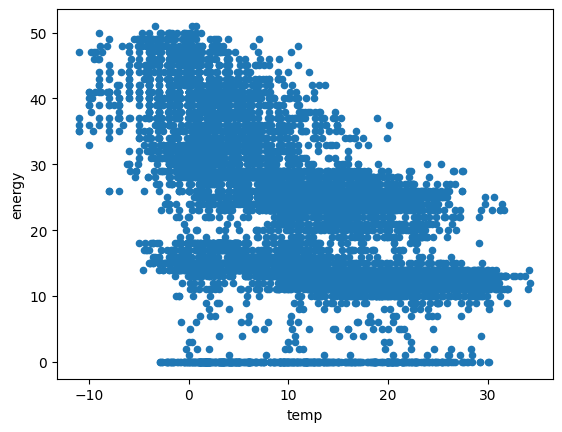

In [ ]:
# Remove data points with energy consumption above 60 GJ/h
data = data.loc[data['energy']<60]
data_sorted = data.sort_values(by=['energy'], ascending=False)
print(data_sorted.head(30))
data.plot(kind="scatter", x="temp", y="energy")

A clear inverse relationship can be observed between temperature and energy consumption:  
the lower the temperature, the higher the energy usage.

Energy consumption values equal to 0 create a distinct "floor" in the plot,  
clearly separated from the rest of the data. This suggests that such values are not representative,  
as only a small portion of data falls near that level.  

These low values likely result from interruptions in data logging —  
for example, if a measurement stops mid-hour, the recorded consumption might fall in the 0–10 GJ range.

In [ ]:
# Display the number of rows and columns in the cleaned dataset
print(data.shape)

(8699, 3)


                     time  temp  energy
5988  2024-09-06 13:00:00  26.1     1.0
4380  2024-07-01 13:00:00  20.5     1.0
4603  2024-07-10 20:00:00  27.2     1.0
7408  2024-11-04 14:00:00   7.7     1.0
4282  2024-06-27 11:00:00  23.9     1.0
7741  2024-11-18 11:00:00   4.0     1.0
7816  2024-11-21 14:00:00   0.0     1.0
7267  2024-10-29 17:00:00  13.6     1.0
3622  2024-05-30 23:00:00  16.2     1.0
4891  2024-07-22 20:00:00  26.0     1.0
5348  2024-08-10 21:00:00  21.7     1.0
5440  2024-08-14 17:00:00  28.4     1.0
4818  2024-07-19 19:00:00  26.3     2.0
6657  2024-10-04 10:00:00  10.1     2.0
5855  2024-09-01 00:00:00  19.7     2.0
7440  2024-11-05 22:00:00   2.0     2.0
5028  2024-07-28 13:00:00  24.6     2.0
7205  2024-10-27 03:00:00  11.5     2.0
7464  2024-11-06 22:00:00   0.8     2.0
5852  2024-08-31 21:00:00  22.3     2.0
7100  2024-10-22 21:00:00  11.1     2.0
7901  2024-11-25 03:00:00  -0.3     2.0
5991  2024-09-06 16:00:00  28.3     2.0
1822  2024-03-16 22:00:00   9.7     2.0


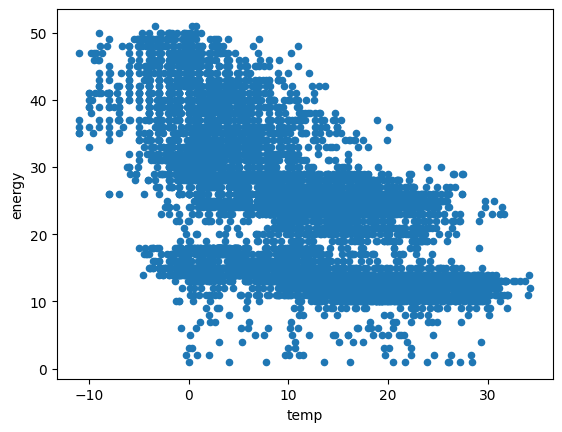

In [ ]:
# Display non-zero energy consumption data in ascending order
# No clear relationship between temperature and low energy usage in the lower value range
data = data.loc[data['energy']>0.001]
data_sorted = data.sort_values(by=['energy'], ascending=True)
print(data_sorted.head(30))
data.plot(kind="scatter", x="temp", y="energy")
print(data.shape)


                     time  temp  energy
5905  2024-09-03 02:00:00  16.5    10.0
5886  2024-09-02 07:00:00  16.3    10.0
4353  2024-06-30 10:00:00  27.6    10.0
5940  2024-09-04 13:00:00  28.7    10.0
7466  2024-11-07 00:00:00   0.4    10.0
7819  2024-11-21 17:00:00  -1.0    10.0
5948  2024-09-04 21:00:00  22.8    10.0
5949  2024-09-04 22:00:00  21.5    10.0
5950  2024-09-04 23:00:00  19.4    10.0
5951  2024-09-05 00:00:00  18.2    10.0
5954  2024-09-05 03:00:00  16.4    10.0
5955  2024-09-05 04:00:00  16.2    10.0
5944  2024-09-04 17:00:00  29.1    10.0
5945  2024-09-04 18:00:00  29.3    10.0
5947  2024-09-04 20:00:00  24.2    10.0
5979  2024-09-06 04:00:00  14.8    10.0
2908  2024-05-01 05:00:00   7.0    10.0
5972  2024-09-05 21:00:00  19.3    10.0
5974  2024-09-05 23:00:00  17.8    10.0
5975  2024-09-06 00:00:00  17.4    10.0
5976  2024-09-06 01:00:00  15.6    10.0
5977  2024-09-06 02:00:00  14.4    10.0
4359  2024-06-30 16:00:00  31.3    10.0
4386  2024-07-01 19:00:00  20.9    10.0


<Axes: xlabel='temp', ylabel='energy'>

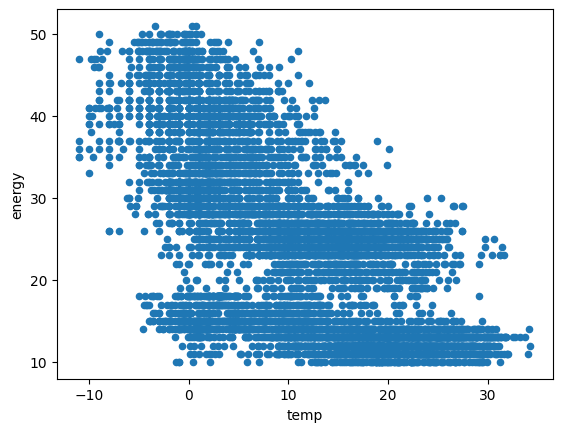

In [ ]:
# Remove data likely caused by missing or partial energy registration during the hour
data = data.loc[data['energy']>9]
data_sorted = data.sort_values(by=['energy'], ascending=True)
print(data_sorted.head(30))
data.plot(kind="scatter", x="temp", y="energy")

In [ ]:
print(data.shape)
# Removing low energy values resulted in approximately 1% data loss (8226 vs 8145),
# which should not negatively affect further estimations


(8097, 3)


In [ ]:
#removing potential duplicates
data = data.drop_duplicates()
print(data.shape)

(8097, 3)


In [ ]:
#checking data types
print(data.dtypes)

time       object
temp      float64
energy    float64
dtype: object


In [ ]:
#change of the date format
data['time'] = pd.to_datetime(data['time'], errors='coerce')
print(data.dtypes)
print(data.head(5))

time      datetime64[ns]
temp             float64
energy           float64
dtype: object
                    time  temp  energy
1809 2024-03-16 09:00:00   9.1    26.0
1810 2024-03-16 10:00:00  11.6    26.0
1811 2024-03-16 11:00:00  13.3    26.0
1812 2024-03-16 12:00:00  14.3    25.0
1813 2024-03-16 13:00:00  15.1    25.0


In [ ]:
# Calculate Pearson correlation between energy consumption and temperature
data['energy'].corr(data['temp'], method='pearson')


np.float64(-0.6501640096162927)

In [ ]:
# Calculate Spearman correlation between energy consumption and temperature
data['energy'].corr(data['temp'], method='spearman')


np.float64(-0.6749867635816743)

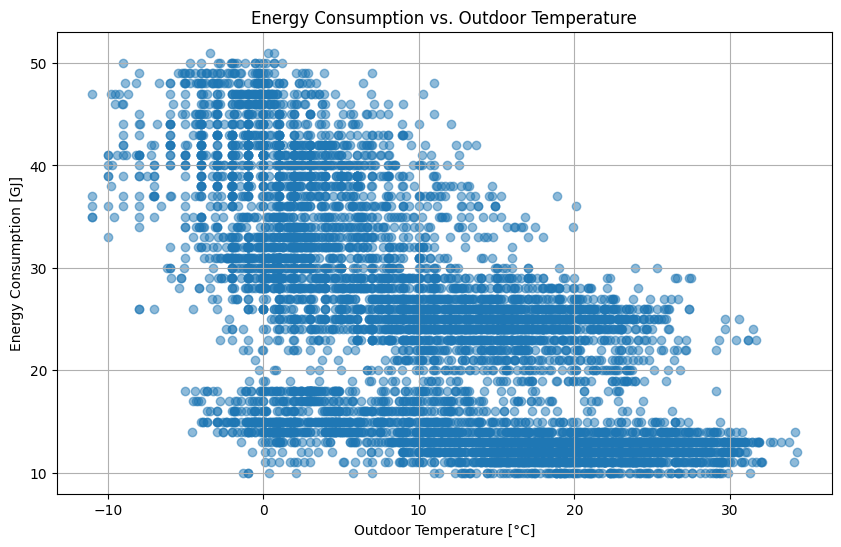

In [ ]:
# Scatter plot with labels and title
plt.figure(figsize=(10, 6))
plt.scatter(data["temp"], data["energy"], alpha=0.5)
plt.title("Energy Consumption vs. Outdoor Temperature")
plt.xlabel("Outdoor Temperature [°C]")
plt.ylabel("Energy Consumption [GJ]")
plt.grid(True)
plt.show()

The absolute value of the Spearman correlation coefficient (e.g., -0.91) is slightly higher  
than that of the Pearson coefficient (e.g., -0.84), suggesting a monotonic but potentially non-linear relationship between temperature and energy consumption.  

This interpretation is supported by the shape of the scatter plot, which hints at a non-perfect linear pattern.

In [ ]:
# Descriptive statistics summary for the dataset
data.describe()

time         temp       energy
count                           8097  8097.000000  8097.000000
mean   2024-09-14 01:27:06.380141056    10.803199    23.817340
min              2024-03-16 09:00:00   -11.000000    10.000000
25%              2024-06-10 17:00:00     2.400000    13.000000
50%              2024-09-10 14:00:00    10.700000    24.000000
75%              2024-12-21 17:00:00    18.100000    31.000000
max              2025-03-16 07:00:00    34.300000    51.000000
std                              NaN     9.161109    10.699295

The descriptive statistics confirm the earlier correlation-based observations:  
both temperature and energy consumption appear to be evenly distributed.  
The mean and median values are close to each other,  
and the 25th and 75th percentiles are symmetrically distributed around the median.

In [ ]:
# Highest energy consumption values and their corresponding temperatures
data_sorted = data.sort_values(by=['energy'], ascending=False)
print(data_sorted.head(10))

                    time  temp  energy
8851 2025-01-03 17:00:00   0.3    51.0
8847 2025-01-03 13:00:00   0.7    51.0
8671 2024-12-27 05:00:00  -3.4    51.0
8667 2024-12-27 01:00:00  -2.9    50.0
8658 2024-12-26 16:00:00  -0.5    50.0
8657 2024-12-26 15:00:00   1.2    50.0
8849 2025-01-03 15:00:00   0.7    50.0
8652 2024-12-26 10:00:00  -1.7    50.0
9958 2025-02-18 20:00:00  -4.0    50.0
8862 2025-01-04 04:00:00  -4.7    50.0


The highest energy consumption values are associated with low temperatures —  
all corresponding temperature readings fall within the first quartile.  
This observation is consistent with the overall trend identified earlier.

In [ ]:
# Highest temperatures and their corresponding energy consumption values
data_sorted = data.sort_values(by=['temp'], ascending=False)
print(data_sorted.head(10))

                    time  temp  energy
4600 2024-07-10 17:00:00  34.3    12.0
4599 2024-07-10 16:00:00  34.2    14.0
4601 2024-07-10 18:00:00  34.1    11.0
4598 2024-07-10 15:00:00  33.8    13.0
4597 2024-07-10 14:00:00  33.3    13.0
4602 2024-07-10 19:00:00  32.8    13.0
4596 2024-07-10 13:00:00  32.6    13.0
4094 2024-06-19 15:00:00  32.1    11.0
4360 2024-06-30 17:00:00  32.0    11.0
4095 2024-06-19 16:00:00  32.0    11.0


The highest temperatures are associated with low energy consumption —  
all but one of the corresponding values fall within the first quartile of energy usage.  
This is consistent with the overall inverse trend observed earlier.

In [ ]:
# Lowest temperatures and their corresponding energy consumption values
data_sorted = data.sort_values(by=['temp'], ascending=True)
print(data_sorted.head(10))

                    time  temp  energy
9943 2025-02-18 05:00:00 -11.0    36.0
9942 2025-02-18 04:00:00 -11.0    35.0
9940 2025-02-18 02:00:00 -11.0    37.0
9941 2025-02-18 03:00:00 -11.0    35.0
8884 2025-01-05 02:00:00 -11.0    47.0
9895 2025-02-16 05:00:00 -10.0    41.0
9939 2025-02-18 01:00:00 -10.0    33.0
9944 2025-02-18 06:00:00 -10.0    36.0
9919 2025-02-17 05:00:00 -10.0    39.0
9918 2025-02-17 04:00:00 -10.0    39.0


The lowest temperatures are associated with high energy consumption —  
all corresponding values fall within the fourth quartile of energy usage.  
This aligns with the overall inverse relationship observed between temperature and consumption.

In [ ]:
#Lowest energy consumption values and their corresponding temperatures
data_sorted = data.sort_values(by=['energy'], ascending=True)
print(data_sorted.head(10))

                    time  temp  energy
5905 2024-09-03 02:00:00  16.5    10.0
5886 2024-09-02 07:00:00  16.3    10.0
4353 2024-06-30 10:00:00  27.6    10.0
5940 2024-09-04 13:00:00  28.7    10.0
7466 2024-11-07 00:00:00   0.4    10.0
7819 2024-11-21 17:00:00  -1.0    10.0
5948 2024-09-04 21:00:00  22.8    10.0
5949 2024-09-04 22:00:00  21.5    10.0
5950 2024-09-04 23:00:00  19.4    10.0
5951 2024-09-05 00:00:00  18.2    10.0


In the subset with the lowest energy consumption values, temperature readings appear quite random.  
This suggests that removing the lower range of energy data was not sufficient to isolate only meaningful observations.  
Some noise or irrelevant data may still remain in the dataset.

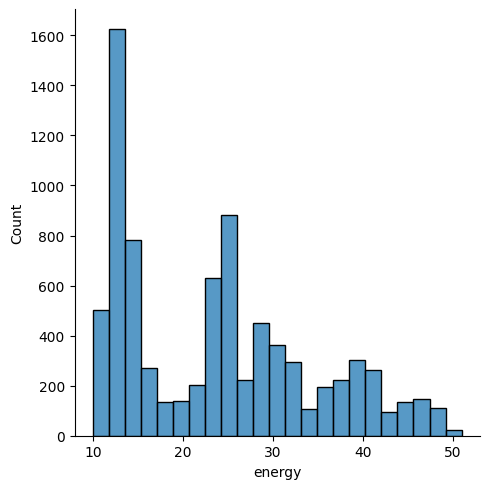

In [ ]:
# Histogram of energy consumption values
sns.displot(data['energy'])

The distribution of energy consumption is non-Gaussian.  
The most frequent hourly consumption value is around 10 GJ.

Above, an arbitrary removal of data was applied to make the dataset more suitable for modeling.  
Below, we create a copy of the original dataset (after dropping missing values) named `df`.  
Further transformations will be applied to this copy, allowing us to compare the effects of  
intuitive data cleaning with more standardized methods, such as IQR-based filtering.

# Modeling and forecasting

<Axes: xlabel='time'>

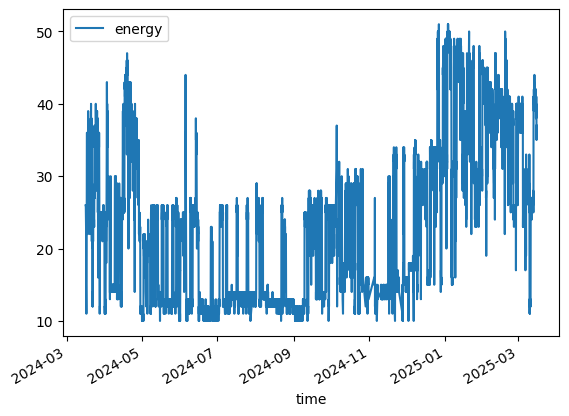

In [ ]:
# Line plot showing energy consumption over time throughout the year
data.plot(kind="line", x="time", y="energy")

In [ ]:
# Saving data after preliminary adjustments for further models

df_raw = data.copy(deep=True)
df_raw.set_index('time', inplace=True)

In [ ]:
# Reset the index

data.reset_index(inplace=True)

In [ ]:
# Keep only the necessary columns
data = data[['time', 'temp', 'energy']]

In [ ]:
# Split the dataset into training and test sets
data_train = data[:-500]
data_test = data[-500:]

In [ ]:
print(f'The training set contains {len(data_train)} records')
print(f'The test set contains {len(data_test)} records')

The training set contains 7597 records
The test set contains 500 records


In [ ]:
# Define ADF (Augmented Dickey-Fuller) stationarity test

from statsmodels.tsa.stattools import adfuller

"""
    Performs the Augmented Dickey-Fuller test on a time series and prints the results.
    Takes a time series and an optional title as input.
"""

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("The data does not have a unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("The data has a unit root and is non-stationary")

In [ ]:
# Perform ADF test on the energy consumption data
adf_test(data_train['energy'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -5.262599
p-value                    0.000007
# lags used               32.000000
# observations          7564.000000
critical value (1%)       -3.431215
critical value (5%)       -2.861922
critical value (10%)      -2.566973
Strong evidence against the null hypothesis
Reject the null hypothesis
The data does not have a unit root and is stationary


Since the time series has been confirmed to be stationary,  
and we may want to account for the influence of an external variable (temperature),  
we will use the ARIMA model or its extended version ARIMAX  
if we choose to include the exogenous variable.

<Axes: >

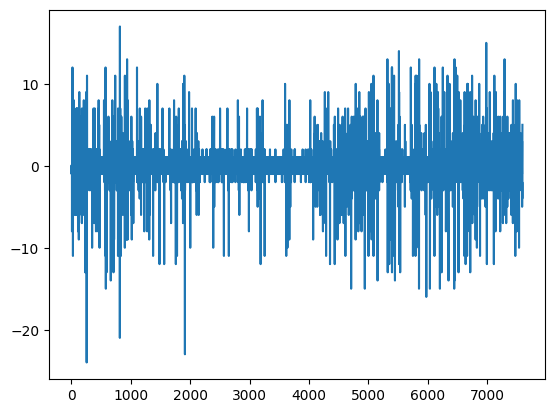

In [ ]:
# Differencing the training data for energy consumption
data_energy_train_diff = data_train['energy'].diff().dropna()
data_energy_train_diff.plot()

The differenced training data for energy consumption exhibits a constant mean and variance,  
which confirms its stationarity.

---



<Axes: >

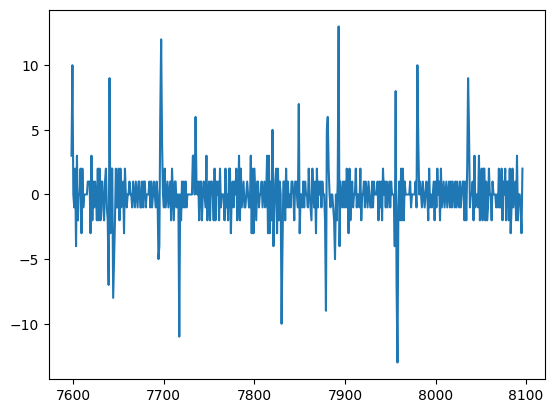

In [ ]:
# Differencing the test data for energy consumption
data_energy_test_diff = data_test['energy'].diff().dropna()
data_energy_test_diff.plot()

The differenced test data for energy consumption exhibits a constant mean and variance,  
confirming its stationarity.

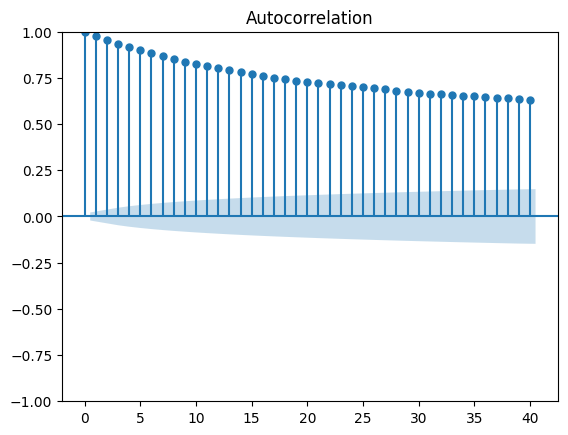

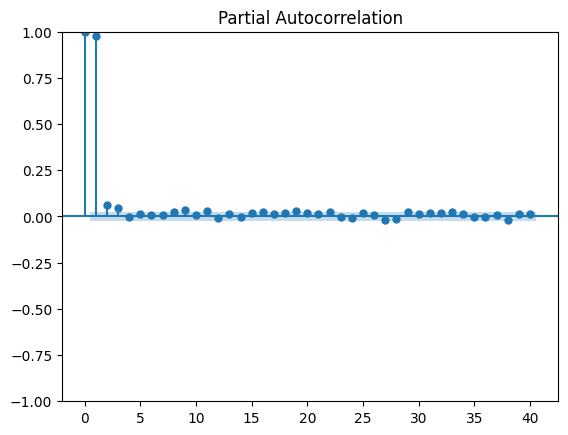

In [ ]:
# ACF and PACF plots for energy consumption
acf_energy = plot_acf(data['energy'])
pacf_energy = plot_pacf(data['energy'])

The ACF plot shows a slow decay of autocorrelation values,  
which suggests that the MA term (q) can be set to 0.  
In contrast, the sharp drop observed in the PACF plot indicates that setting the AR term (p) to 0 is not appropriate.

In [ ]:
# Fit ARIMA model (p=0, d=1, q=2) to training data and make predictions on the test set
model_e = sm.tsa.arima.ARIMA(data_train['energy'], order=(0, 1, 2))
results_e = model_e.fit()
predictions_e = results_e.predict(start=data_test.index[0], end=data_test.index[-1])
print(results_e.summary())
print(predictions_e)

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                 7597
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -17291.471
Date:                Fri, 04 Jul 2025   AIC                          34588.943
Time:                        07:46:32   BIC                          34609.749
Sample:                             0   HQIC                         34596.083
                               - 7597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0714      0.006    -11.957      0.000      -0.083      -0.060
ma.L2         -0.0556      0.009     -6.435      0.000      -0.072      -0.039
sigma2         5.5560      0.033    169.201      0.0

In [ ]:
# Fit ARIMAX model (with temperature as exogenous variable) to training data and make predictions
model_e_t = sm.tsa.arima.ARIMA(endog=data_train['energy'], exog=data_train['temp'], order=(0, 1, 2))
results_e_t = model_e_t.fit()
predictions_e_t = results_e_t.predict(start=data_test.index[0], end=data_test.index[-1], exog=data_test[['temp']])
print(results_e_t.summary())
print(predictions_e_t)

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                 7597
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -17288.351
Date:                Fri, 04 Jul 2025   AIC                          34584.701
Time:                        07:46:33   BIC                          34612.443
Sample:                             0   HQIC                         34594.221
                               - 7597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -0.0496      0.013     -3.794      0.000      -0.075      -0.024
ma.L1         -0.0720      0.006    -11.996      0.000      -0.084      -0.060
ma.L2         -0.0551      0.009     -6.379      0.0

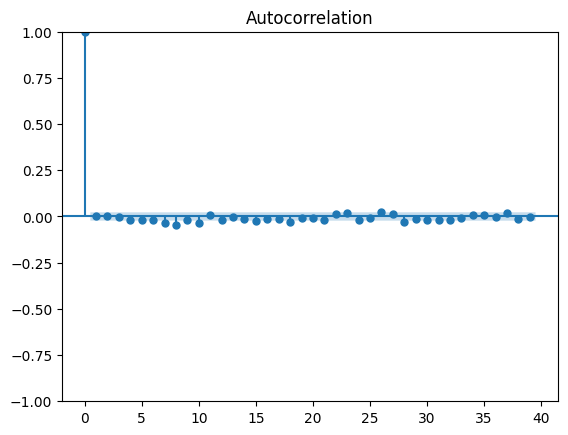

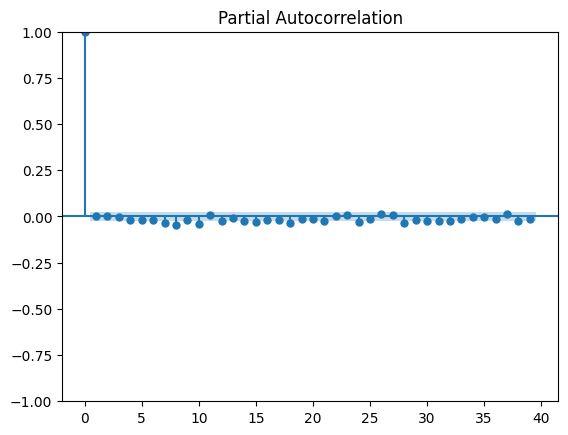

In [ ]:
# ACF and PACF plots for residuals
acf_res = plot_acf(results_e.resid)
pacf_res = plot_pacf(results_e.resid)

The residuals are very small and resemble white noise,  
indicating that the model is well-specified and all relevant predictors have been appropriately included.

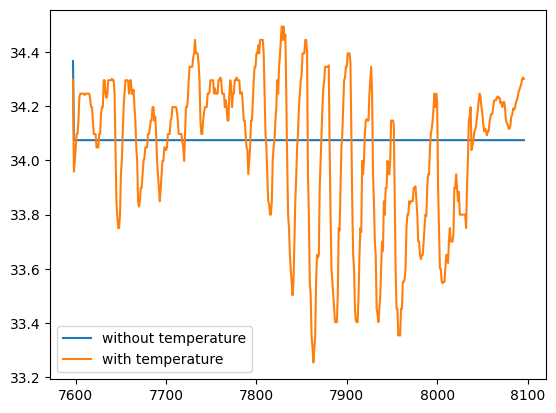

In [ ]:
# Plot predictions based on the time series alone vs. with temperature as an exogenous variable
plt.plot(predictions_e, label='without temperature')
plt.plot(predictions_e_t, label='with temperature')
plt.legend()
plt.show()

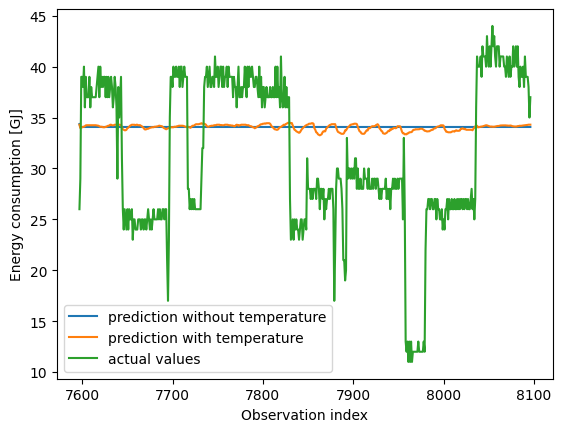

In [ ]:
# Predictions vs. actual energy consumption values
plt.plot(predictions_e, label='prediction without temperature')
plt.plot(predictions_e_t, label='prediction with temperature')
plt.plot(data_test['energy'], label='actual values')
plt.ylabel('Energy consumption [GJ]')
plt.xlabel('Observation index')
plt.legend()
plt.show()

In [ ]:
# Model accuracy

score_arima = np.sqrt(mean_squared_error(data_test['energy'], predictions_e_t))
print(f'The RMSE of the ARIMA model (with temperature) on the test set is: {score_arima}')

The RMSE of the ARIMA model (with temperature) on the test set is: 7.862796636308646


The plots above show that predictions incorporating temperature as an exogenous variable  
are more accurate than those generated without it. This improvement is due to the model’s ability  
to capture the correlation between temperature and energy consumption,  
which reflects in daily fluctuations in the forecasted values.

However, both prediction series tend to hover closely around the mean and median,  
and do not fully capture the variability observed in the actual test data.

ARIMA models are generally not ideal for forecasting highly volatile or high-variance time series,  
as they primarily model the mean of the data rather than its variance.  
In cases where data exhibits high variability, the variance is not constant —  
a condition known as **heteroskedasticity** — which violates one of the key assumptions of the ARIMA framework.

# Machine learning with multiple features

In [ ]:
# Display the dataset
data


time  temp  energy
0    2024-03-16 09:00:00   9.1    26.0
1    2024-03-16 10:00:00  11.6    26.0
2    2024-03-16 11:00:00  13.3    26.0
3    2024-03-16 12:00:00  14.3    25.0
4    2024-03-16 13:00:00  15.1    25.0
...                  ...   ...     ...
8092 2025-03-16 03:00:00   1.5    39.0
8093 2025-03-16 04:00:00   1.3    39.0
8094 2025-03-16 05:00:00   0.9    38.0
8095 2025-03-16 06:00:00   0.8    35.0
8096 2025-03-16 07:00:00   0.9    37.0

[8097 rows x 3 columns]

In [ ]:
# Set 'time' column as the index
data.set_index('time', inplace=True)

In [ ]:
# Display the final dataset used for modeling
data

temp  energy
time                             
2024-03-16 09:00:00   9.1    26.0
2024-03-16 10:00:00  11.6    26.0
2024-03-16 11:00:00  13.3    26.0
2024-03-16 12:00:00  14.3    25.0
2024-03-16 13:00:00  15.1    25.0
...                   ...     ...
2025-03-16 03:00:00   1.5    39.0
2025-03-16 04:00:00   1.3    39.0
2025-03-16 05:00:00   0.9    38.0
2025-03-16 06:00:00   0.8    35.0
2025-03-16 07:00:00   0.9    37.0

[8097 rows x 2 columns]

In [ ]:
# Set 'time' as index for both previously split training and test datasets
data_train.set_index('time', inplace=True)
data_test.set_index('time', inplace=True)

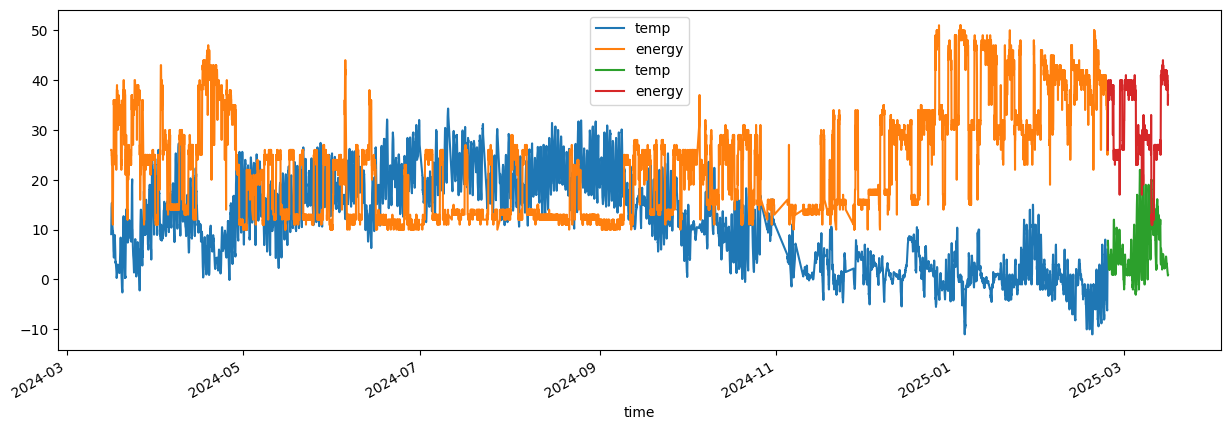

In [ ]:
# Visualize training and test datasets
fig, ax = plt.subplots(figsize=(15, 5))
data_train.plot(ax=ax, label='training')
data_test.plot(ax=ax, label='test')
ax.legend()
plt.show()

<Axes: xlabel='time'>

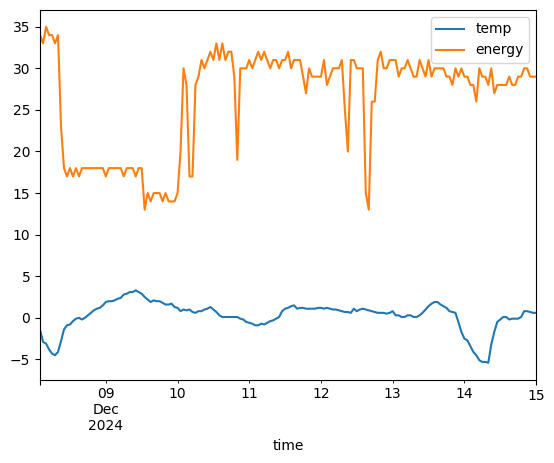

In [ ]:
# Display weekly slices of the dataset

data.loc[(data.index > '2024-12-01 01:00:00') & (data.index < '2024-12-08 01:00:00')].plot()
data.loc[(data.index > '2024-12-08 01:00:00') & (data.index < '2024-12-15 01:00:00')].plot()

No consistent weekly trends are observed in the data.  
The patterns of energy consumption and temperature appear to vary significantly from week to week.

# Feature engineering

In [ ]:
def create_features(data):
    """
    Feature engineering function:
    Generates time-based, lagged, and rolling features
    for temperature and energy consumption to support predictive modeling.
    """
    # Rolling averages of temperature
    data['temp_MA_7'] = data['temp'].rolling(window=7).mean()
    data['temp_MA_14'] = data['temp'].rolling(window=14).mean()
    data['temp_MA_21'] = data['temp'].rolling(window=21).mean()

    # Rolling averages of energy consumption
    data['energy_MA_7'] = data['energy'].rolling(window=7).mean()
    data['energy_MA_14'] = data['energy'].rolling(window=14).mean()
    data['energy_MA_21'] = data['energy'].rolling(window=21).mean()

    # First-order differences
    data['temp_diff'] = data['temp'].diff()
    data['energy_diff'] = data['energy'].diff()

    # Time-based calendar features
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Lag features for past temperature and energy values (1 to 30 steps)
    lags = list(range(1, 31))
    for i in lags:
        data[f'temp_lag_{i}'] = data['temp'].shift(i)
        data[f'energy_lag_{i}'] = data['energy'].shift(i)

    return data

In [ ]:
# Apply the feature engineering function to the dataset
data_f = create_features(data)

In [ ]:
# Display the list of columns in the new feature-enhanced dataset
data_f.columns

Index(['temp', 'energy', 'temp_MA_7', 'temp_MA_14', 'temp_MA_21',
       'energy_MA_7', 'energy_MA_14', 'energy_MA_21', 'temp_diff',
       'energy_diff', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year', 'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23'

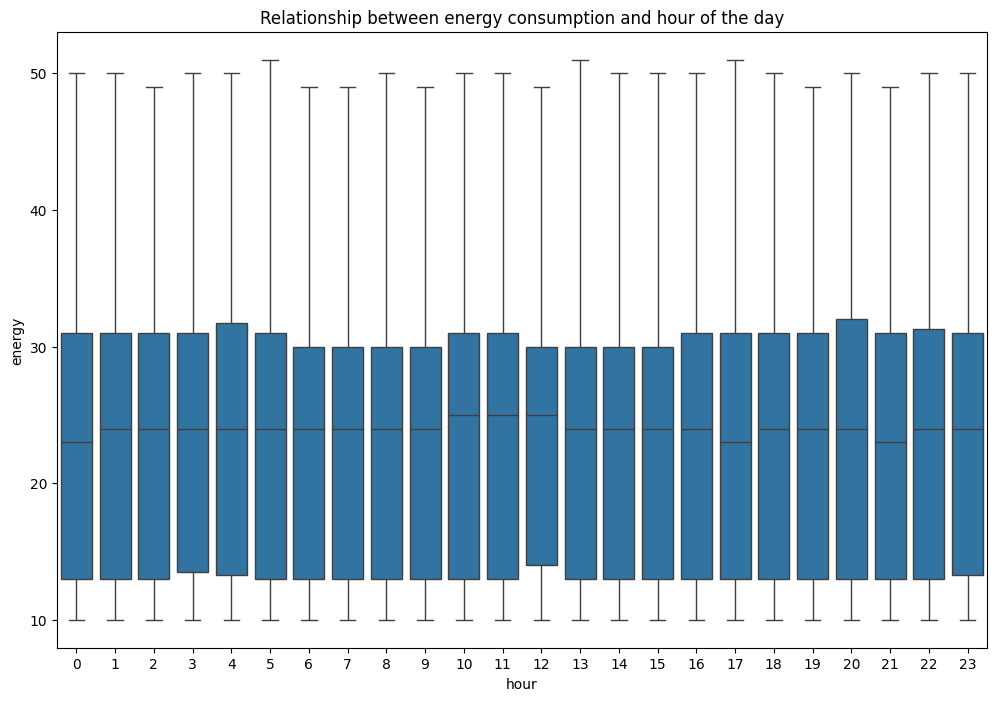

In [ ]:
# Visualize the relationship between hour of the day and energy consumption
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=data_f, x='hour', y='energy')
ax.set_title('Relationship between energy consumption and hour of the day')
plt.show()

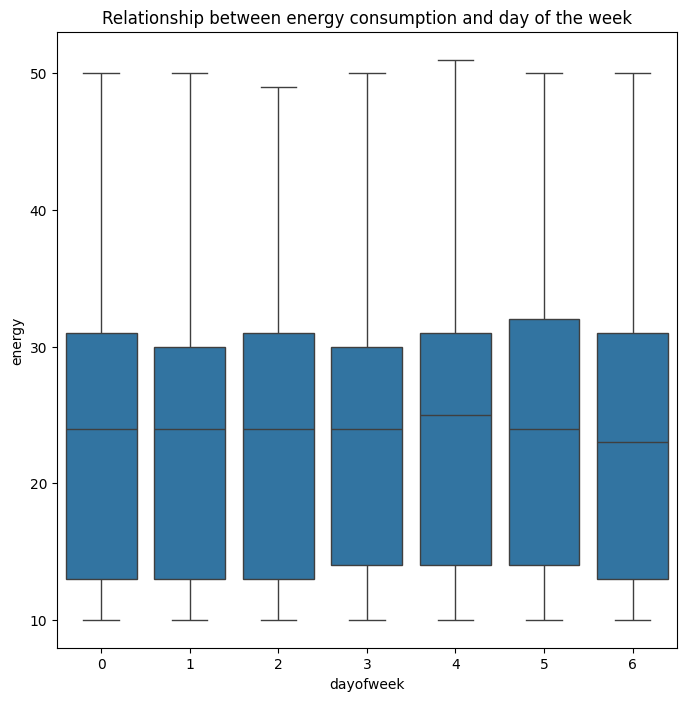

In [ ]:
# Visualize the relationship between day of the week and energy consumption
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=data_f, x='dayofweek', y='energy')
ax.set_title('Relationship between energy consumption and day of the week')
plt.show()

There are no significant differences in energy consumption across different days of the week or hours of the day.  
This suggests that energy usage is relatively stable throughout the week and the daily cycle.

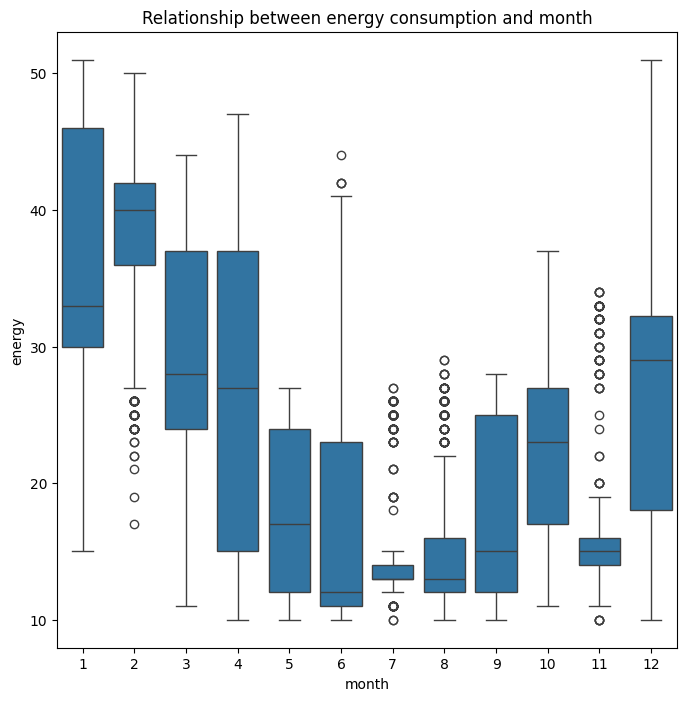

In [ ]:
# Visualize the relationship between month and energy consumption
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=data_f, x='month', y='energy')
ax.set_title('Relationship between energy consumption and month')
plt.show()

There is considerable variation in energy consumption across different months,  
indicating the presence of strong seasonal effects in the dataset.

## Model selection: XGBoost

We selected **XGBoost** as the modeling algorithm due to its efficiency and flexibility as a gradient boosting implementation for regression tasks.  
Although it is not inherently designed for time series forecasting, it can be effectively applied to such problems  
by transforming the data into a supervised learning format.

This approach requires creating time-based features such as lags, rolling averages, and calendar features,  
allowing the model to learn from past observations to predict future values.

In [ ]:
# Apply the feature engineering function to training and test datasets
data_train_f = create_features(data_train)
data_test_f = create_features(data_test)

/tmp/ipython-input-48-1897403199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp_MA_7'] = data['temp'].rolling(window=7).mean()
/tmp/ipython-input-48-1897403199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temp_MA_14'] = data['temp'].rolling(window=14).mean()
/tmp/ipython-input-48-1897403199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [ ]:
# Display the transformed training and test datasets
data_train_f
data_test_f

temp  energy  temp_MA_7  temp_MA_14  temp_MA_21  \
time                                                                   
2025-02-23 12:00:00   7.0    26.0        NaN         NaN         NaN   
2025-02-23 13:00:00   7.8    29.0        NaN         NaN         NaN   
2025-02-23 14:00:00   7.0    39.0        NaN         NaN         NaN   
2025-02-23 15:00:00   6.0    39.0        NaN         NaN         NaN   
2025-02-23 16:00:00   5.0    38.0        NaN         NaN         NaN   
...                   ...     ...        ...         ...         ...   
2025-03-16 03:00:00   1.5    39.0   2.242857    3.064286    3.176190   
2025-03-16 04:00:00   1.3    39.0   1.985714    2.828571    3.095238   
2025-03-16 05:00:00   0.9    38.0   1.728571    2.564286    3.004762   
2025-03-16 06:00:00   0.8    35.0   1.485714    2.307143    2.919048   
2025-03-16 07:00:00   0.9    37.0   1.285714    2.107143    2.819048   

                     energy_MA_7  energy_MA_14  energy_MA_21  temp_diff  \
time                                                                      
2025-02-23 12:00:00          NaN           NaN           NaN        NaN   
2025-02-23 13:00:00          NaN           NaN           NaN        0.8   
2025-02-23 14:00:00          NaN           NaN           NaN       -0.8   
2025-02-23 15:00:00          NaN           NaN           NaN       -1.0   
2025-02-23 16:00:00          NaN           NaN           NaN       -1.0   
...                          ...           ...           ...        ...   
2025-03-16 03:00:00    39.285714     39.785714     39.904762       -0.2   
2025-03-16 04:00:00    39.285714     39.642857     39.904762       -0.2   
2025-03-16 05:00:00    39.142857     39.357143     39.761905       -0.4   
2025-03-16 06:00:00    38.428571     39.000000     39.571429       -0.1   
2025-03-16 07:00:00    38.285714     38.642857     39.428571        0.1   

                     energy_diff  ...  temp_lag_26  energy_lag_26  \
time                              ...                               
2025-02-23 12:00:00          NaN  ...          NaN            NaN   
2025-02-23 13:00:00          3.0  ...          NaN            NaN   
2025-02-23 14:00:00         10.0  ...          NaN            NaN   
2025-02-23 15:00:00          0.0  ...          NaN            NaN   
2025-02-23 16:00:00         -1.0  ...          NaN            NaN   
...                          ...  ...          ...            ...   
2025-03-16 03:00:00          0.0  ...          2.3           41.0   
2025-03-16 04:00:00          0.0  ...          2.2           40.0   
2025-03-16 05:00:00         -1.0  ...          2.3           40.0   
2025-03-16 06:00:00         -3.0  ...          2.3           39.0   
2025-03-16 07:00:00          2.0  ...          2.7           41.0   

                     temp_lag_27  energy_lag_27  temp_lag_28  energy_lag_28  \
time                                                                          
2025-02-23 12:00:00          NaN            NaN          NaN            NaN   
2025-02-23 13:00:00          NaN            NaN          NaN            NaN   
2025-02-23 14:00:00          NaN            NaN          NaN            NaN   
2025-02-23 15:00:00          NaN            NaN          NaN            NaN   
2025-02-23 16:00:00          NaN            NaN          NaN            NaN   
...                          ...            ...          ...            ...   
2025-03-16 03:00:00          2.5           41.0          2.5           41.0   
2025-03-16 04:00:00          2.3           41.0          2.5           41.0   
2025-03-16 05:00:00          2.2           40.0          2.3           41.0   
2025-03-16 06:00:00          2.3           40.0          2.2           40.0   
2025-03-16 07:00:00          2.3           39.0          2.3           40.0   

                     temp_lag_29  energy_lag_29  temp_lag_30  energy_lag_30  
time                                                                         
2025-02-23 12:00:00       

In [ ]:
# Display the column names for feature selection
data.columns

Index(['temp', 'energy', 'temp_MA_7', 'temp_MA_14', 'temp_MA_21',
       'energy_MA_7', 'energy_MA_14', 'energy_MA_21', 'temp_diff',
       'energy_diff', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year', 'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23'

In [ ]:
# Define training and test feature sets for the model

FEATURES = ['temp', 'temp_MA_7', 'temp_MA_14', 'temp_MA_21',
       'energy_MA_7', 'energy_MA_14', 'energy_MA_21', 'temp_diff',
       'energy_diff', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year', 'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23', 'energy_lag_23', 'temp_lag_24', 'energy_lag_24',
       'temp_lag_25', 'energy_lag_25', 'temp_lag_26', 'energy_lag_26',
       'temp_lag_27', 'energy_lag_27', 'temp_lag_28', 'energy_lag_28',
       'temp_lag_29', 'energy_lag_29', 'temp_lag_30', 'energy_lag_30']

TARGET = 'energy'

In [ ]:
# Define training and test sets for the model

X_train = data_train_f[FEATURES]
y_train = data_train_f[TARGET]

X_test = data_test_f[FEATURES]
y_test = data_test_f[TARGET]

In [ ]:
# Create XGBoost regression model
reg = xgb.XGBRegressor(n_estimators=5000, early_stopping_rounds=50, learning_rate=0.001)

# Train the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:10.68237	validation_1-rmse:10.95641
[1]	validation_0-rmse:10.67189	validation_1-rmse:10.94539
[2]	validation_0-rmse:10.66142	validation_1-rmse:10.93438
[3]	validation_0-rmse:10.65096	validation_1-rmse:10.92338
[4]	validation_0-rmse:10.64050	validation_1-rmse:10.91239
[5]	validation_0-rmse:10.63006	validation_1-rmse:10.90142
[6]	validation_0-rmse:10.61963	validation_1-rmse:10.89045
[7]	validation_0-rmse:10.60922	validation_1-rmse:10.87950
[8]	validation_0-rmse:10.59881	validation_1-rmse:10.86856
[9]	validation_0-rmse:10.58841	validation_1-rmse:10.85763
[10]	validation_0-rmse:10.57802	validation_1-rmse:10.84671
[11]	validation_0-rmse:10.56764	validation_1-rmse:10.83580
[12]	validation_0-rmse:10.55728	validation_1-rmse:10.82490
[13]	validation_0-rmse:10.54691	validation_1-rmse:10.81407
[14]	validation_0-rmse:10.53656	validation_1-rmse:10.80319
[15]	validation_0-rmse:10.52622	validation_1-rmse:10.79237
[16]	validation_0-rmse:10.51588	validation_1-rmse:10.78157
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

By setting a low learning rate (0.001) and a high number of trees (5000),  
the model avoids overfitting and converges gradually,  
achieving predictions with a very low root mean squared error (RMSE).

# Feature importances

In [ ]:
# feature importances table creation
fi = pd.DataFrame(data = reg.feature_importances_, index = FEATURES, columns = ['importance'])

In [ ]:
# feature importnaces display
fi

importance
temp             0.000618
temp_MA_7        0.000244
temp_MA_14       0.000082
temp_MA_21       0.000081
energy_MA_7      0.016941
...                   ...
energy_lag_28    0.000762
temp_lag_29      0.000120
energy_lag_29    0.000099
temp_lag_30      0.008094
energy_lag_30    0.000392

[75 rows x 1 columns]

Very low importance of temperature

<Axes: title={'center': 'Feature Importance'}>

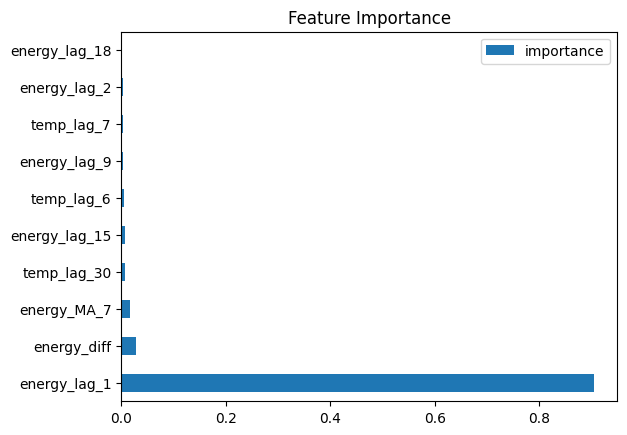

In [ ]:
# top 10 most important features

fi.sort_values('importance', ascending=False).head(10).plot(kind='barh', title='Feature Importance')

Practically the only significant feature is the 1-hour lag of energy consumption.  
This suggests that the current energy usage is highly dependent on its immediate past value,  
while other features contribute minimally to the model’s predictions.

# Predictions on the test set

In [ ]:
# Add predicted values to the test DataFrame
data_test_f['prediction'] = reg.predict(X_test)

/tmp/ipython-input-63-3917649384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_f['prediction'] = reg.predict(X_test)


In [ ]:
# Display the test dataset with added predicted energy consumption values
data_test_f

temp  energy  temp_MA_7  temp_MA_14  temp_MA_21  \
time                                                                   
2025-02-23 12:00:00   7.0    26.0        NaN         NaN         NaN   
2025-02-23 13:00:00   7.8    29.0        NaN         NaN         NaN   
2025-02-23 14:00:00   7.0    39.0        NaN         NaN         NaN   
2025-02-23 15:00:00   6.0    39.0        NaN         NaN         NaN   
2025-02-23 16:00:00   5.0    38.0        NaN         NaN         NaN   
...                   ...     ...        ...         ...         ...   
2025-03-16 03:00:00   1.5    39.0   2.242857    3.064286    3.176190   
2025-03-16 04:00:00   1.3    39.0   1.985714    2.828571    3.095238   
2025-03-16 05:00:00   0.9    38.0   1.728571    2.564286    3.004762   
2025-03-16 06:00:00   0.8    35.0   1.485714    2.307143    2.919048   
2025-03-16 07:00:00   0.9    37.0   1.285714    2.107143    2.819048   

                     energy_MA_7  energy_MA_14  energy_MA_21  temp_diff  \
time                                                                      
2025-02-23 12:00:00          NaN           NaN           NaN        NaN   
2025-02-23 13:00:00          NaN           NaN           NaN        0.8   
2025-02-23 14:00:00          NaN           NaN           NaN       -0.8   
2025-02-23 15:00:00          NaN           NaN           NaN       -1.0   
2025-02-23 16:00:00          NaN           NaN           NaN       -1.0   
...                          ...           ...           ...        ...   
2025-03-16 03:00:00    39.285714     39.785714     39.904762       -0.2   
2025-03-16 04:00:00    39.285714     39.642857     39.904762       -0.2   
2025-03-16 05:00:00    39.142857     39.357143     39.761905       -0.4   
2025-03-16 06:00:00    38.428571     39.000000     39.571429       -0.1   
2025-03-16 07:00:00    38.285714     38.642857     39.428571        0.1   

                     energy_diff  ...  energy_lag_26  temp_lag_27  \
time                              ...                               
2025-02-23 12:00:00          NaN  ...            NaN          NaN   
2025-02-23 13:00:00          3.0  ...            NaN          NaN   
2025-02-23 14:00:00         10.0  ...            NaN          NaN   
2025-02-23 15:00:00          0.0  ...            NaN          NaN   
2025-02-23 16:00:00         -1.0  ...            NaN          NaN   
...                          ...  ...            ...          ...   
2025-03-16 03:00:00          0.0  ...           41.0          2.5   
2025-03-16 04:00:00          0.0  ...           40.0          2.3   
2025-03-16 05:00:00         -1.0  ...           40.0          2.2   
2025-03-16 06:00:00         -3.0  ...           39.0          2.3   
2025-03-16 07:00:00          2.0  ...           41.0          2.3   

                     energy_lag_27  temp_lag_28  energy_lag_28  temp_lag_29  \
time                                                                          
2025-02-23 12:00:00            NaN          NaN            NaN          NaN   
2025-02-23 13:00:00            NaN          NaN            NaN          NaN   
2025-02-23 14:00:00            NaN          NaN            NaN          NaN   
2025-02-23 15:00:00            NaN          NaN            NaN          NaN   
2025-02-23 16:00:00            NaN          NaN            NaN          NaN   
...                            ...          ...            ...          ...   
2025-03-16 03:00:00           41.0          2.5           41.0          2.5   
2025-03-16 04:00:00           41.0          2.5           41.0          2.5   
2025-03-16 05:00:00           40.0          2.3           41.0          2.5   
2025-03-16 06:00:00           40.0          2.2           40.0          2.3   
2025-03-16 07:00:00           39.0          2.3           40.0          2.2   

                     energy_lag_29  temp_lag_30  energy_lag_30  prediction  
time                                                                        
2025-02-23 12:00:00         

In [ ]:
# Merge original dataset with predictions
data_final = data_f.merge(data_test_f[['prediction']], how='left', left_index=True, right_index=True)


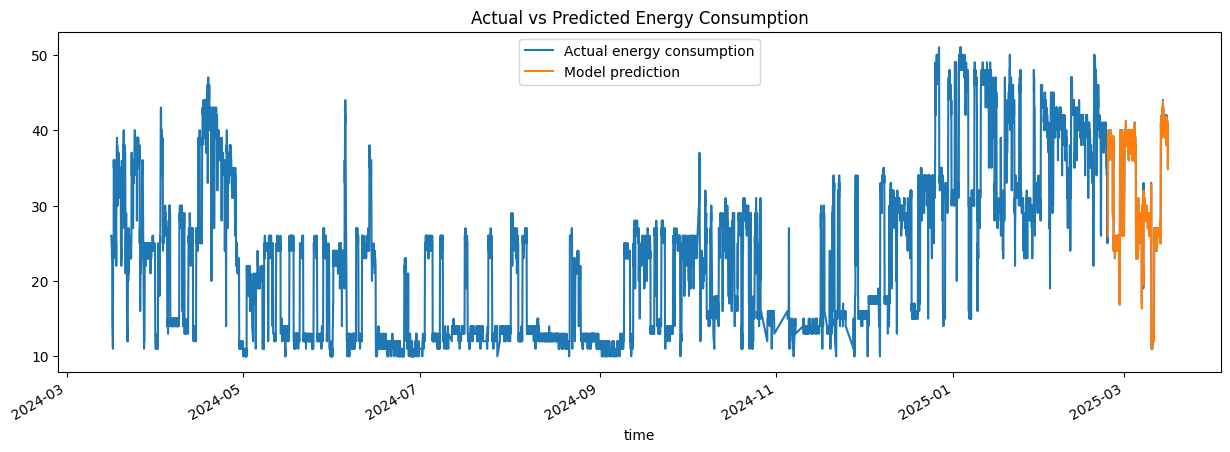

In [ ]:
# Plot actual energy data with model predictions over the full time range and save the plot as png

ax = data[['energy']].plot(figsize=(15, 5))
data_final['prediction'].plot(ax=ax)
plt.legend(['Actual energy consumption', 'Model prediction'])
ax.set_title('Actual vs Predicted Energy Consumption')
plt.savefig('actual_vs_predicted_full_hourly.png')
plt.show()

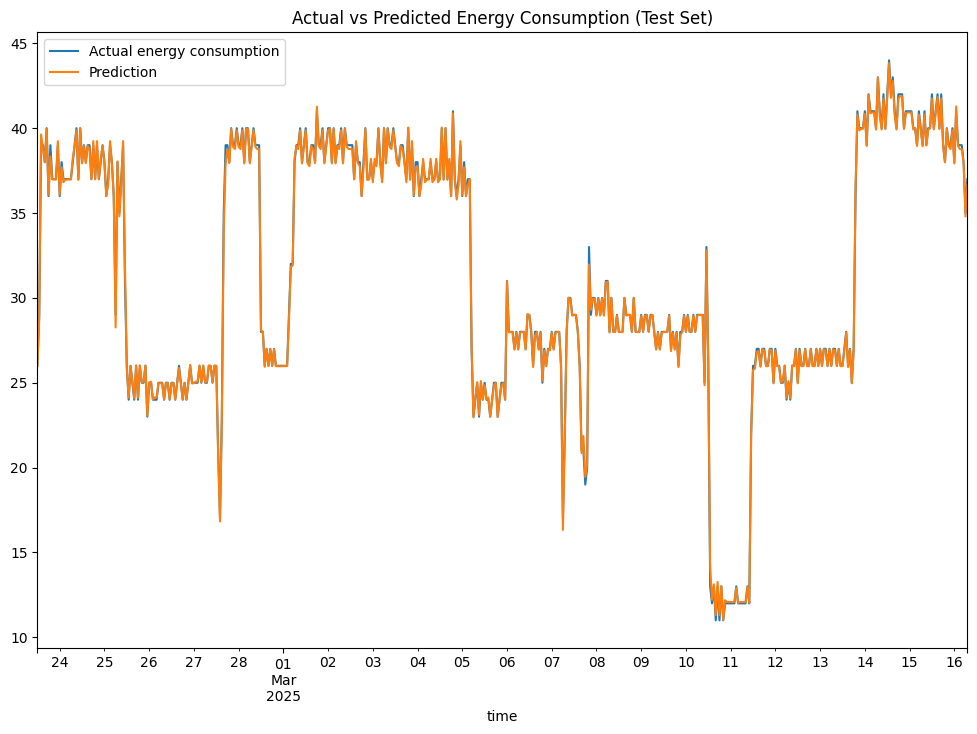

In [ ]:
# Plot actual vs predicted energy consumption on the test dataset

ax = data_test_f[['energy', 'prediction']].plot(figsize=(12, 8))
plt.legend(['Actual energy consumption', 'Prediction'])
ax.set_title('Actual vs Predicted Energy Consumption (Test Set)')
plt.savefig('actual_vs_predicted_xgb_hourly.png')
plt.show()

In [ ]:
# Model accuracy – XGBoost
score_xgb = np.sqrt(mean_squared_error(data_test_f['energy'], data_test_f['prediction']))
print(f'RMSE on the test set for the XGBoost model: {score_xgb}')

RMSE on the test set for the XGBoost model: 0.17642514507438894


In [ ]:
# Model accuracy – ARIMAX

print(f'RMSE on the test set for the ARIMAX model: {score_arima}')

RMSE on the test set for the ARIMAX model: 7.862796636308646


## Final Model Evaluation and Conclusions

The predicted values produced by the model are very close to the actual observations.  
The XGBoost model achieved a significantly lower RMSE (0.18) compared to the ARIMAX model (7.86).  
The comparison plot between predictions and actual values also shows that the two lines almost perfectly overlap.

Temperature had a negligible impact on prediction accuracy.  
The most important feature by far was the **1-hour lag of energy consumption**.  
Other engineered features contributed minimally, as shown in the feature importance analysis.

The XGBoost model is well-trained and produces highly accurate results.  
Minor improvements could potentially be achieved through:
- **Feature standardization** (though not typically required for XGBoost, as it is scale-invariant),
- **Dimensionality reduction**, e.g. using PCA, especially considering that only a few of the engineered features proved truly relevant.

In summary, XGBoost provided a robust and interpretable model for short-term energy consumption forecasting,  
with strong performance and minimal need for additional tuning.



### Time Series Cross-Validation (10 splits)

To evaluate the stability and generalization of the XGBoost model,  
we applied time series cross-validation using `TimeSeriesSplit` with 10 folds.

The model achieved an **average RMSE of 0.72**,  
with most folds showing very low error (< 0.6),  
but some indicating slightly higher variance – likely due to structural or seasonal shifts in the data.

This confirms that the model is well-calibrated overall,  
but could benefit from further adjustments (e.g., seasonal features, regime detection) in high-variance periods.


# To better suit the data to business decisions data will be further aggregated to daily energy usages, as most of production planning/energy optimization happens on a daily level. Temperature daily averages will be used.

In [ ]:
# Display data
data

temp  energy  temp_MA_7  temp_MA_14  temp_MA_21  \
time                                                                   
2024-03-16 09:00:00   9.1    26.0        NaN         NaN         NaN   
2024-03-16 10:00:00  11.6    26.0        NaN         NaN         NaN   
2024-03-16 11:00:00  13.3    26.0        NaN         NaN         NaN   
2024-03-16 12:00:00  14.3    25.0        NaN         NaN         NaN   
2024-03-16 13:00:00  15.1    25.0        NaN         NaN         NaN   
...                   ...     ...        ...         ...         ...   
2025-03-16 03:00:00   1.5    39.0   2.242857    3.064286    3.176190   
2025-03-16 04:00:00   1.3    39.0   1.985714    2.828571    3.095238   
2025-03-16 05:00:00   0.9    38.0   1.728571    2.564286    3.004762   
2025-03-16 06:00:00   0.8    35.0   1.485714    2.307143    2.919048   
2025-03-16 07:00:00   0.9    37.0   1.285714    2.107143    2.819048   

                     energy_MA_7  energy_MA_14  energy_MA_21  temp_diff  \
time                                                                      
2024-03-16 09:00:00          NaN           NaN           NaN        NaN   
2024-03-16 10:00:00          NaN           NaN           NaN        2.5   
2024-03-16 11:00:00          NaN           NaN           NaN        1.7   
2024-03-16 12:00:00          NaN           NaN           NaN        1.0   
2024-03-16 13:00:00          NaN           NaN           NaN        0.8   
...                          ...           ...           ...        ...   
2025-03-16 03:00:00    39.285714     39.785714     39.904762       -0.2   
2025-03-16 04:00:00    39.285714     39.642857     39.904762       -0.2   
2025-03-16 05:00:00    39.142857     39.357143     39.761905       -0.4   
2025-03-16 06:00:00    38.428571     39.000000     39.571429       -0.1   
2025-03-16 07:00:00    38.285714     38.642857     39.428571        0.1   

                     energy_diff  ...  temp_lag_26  energy_lag_26  \
time                              ...                               
2024-03-16 09:00:00          NaN  ...          NaN            NaN   
2024-03-16 10:00:00          0.0  ...          NaN            NaN   
2024-03-16 11:00:00          0.0  ...          NaN            NaN   
2024-03-16 12:00:00         -1.0  ...          NaN            NaN   
2024-03-16 13:00:00          0.0  ...          NaN            NaN   
...                          ...  ...          ...            ...   
2025-03-16 03:00:00          0.0  ...          2.3           41.0   
2025-03-16 04:00:00          0.0  ...          2.2           40.0   
2025-03-16 05:00:00         -1.0  ...          2.3           40.0   
2025-03-16 06:00:00         -3.0  ...          2.3           39.0   
2025-03-16 07:00:00          2.0  ...          2.7           41.0   

                     temp_lag_27  energy_lag_27  temp_lag_28  energy_lag_28  \
time                                                                          
2024-03-16 09:00:00          NaN            NaN          NaN            NaN   
2024-03-16 10:00:00          NaN            NaN          NaN            NaN   
2024-03-16 11:00:00          NaN            NaN          NaN            NaN   
2024-03-16 12:00:00          NaN            NaN          NaN            NaN   
2024-03-16 13:00:00          NaN            NaN          NaN            NaN   
...                          ...            ...          ...            ...   
2025-03-16 03:00:00          2.5           41.0          2.5           41.0   
2025-03-16 04:00:00          2.3           41.0          2.5           41.0   
2025-03-16 05:00:00          2.2           40.0          2.3           41.0   
2025-03-16 06:00:00          2.3           40.0          2.2           40.0   
2025-03-16 07:00:00          2.3           39.0          2.3           40.0   

                     temp_lag_29  energy_lag_29  temp_lag_30  energy_lag_30  
time                                                                         
2024-03-16 09:00:00       

In [ ]:
# Preparing for further transformations, moving time out of index
daily_data = data[['energy', 'temp']]
daily_data['date'] = daily_data.index.date

/tmp/ipython-input-71-4167388339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['date'] = daily_data.index.date


In [ ]:
# Aggregate basic data based on the date
daily_data = daily_data.groupby('date').agg({'energy': 'sum', 'temp': 'mean'})

In [ ]:
# Deleting first and last day data - not complete data and displaying the data
daily_data = daily_data.iloc[1:-1]
daily_data

energy       temp
date                         
2024-03-17   667.0   6.262500
2024-03-18   809.0   1.808333
2024-03-19   681.0   3.486364
2024-03-20   779.0   5.070833
2024-03-21   614.0   7.558333
...            ...        ...
2025-03-11   473.0  10.770833
2025-03-12   622.0  10.416667
2025-03-13   702.0   8.875000
2025-03-14   991.0   3.762500
2025-03-15   963.0   3.175000

[355 rows x 2 columns]

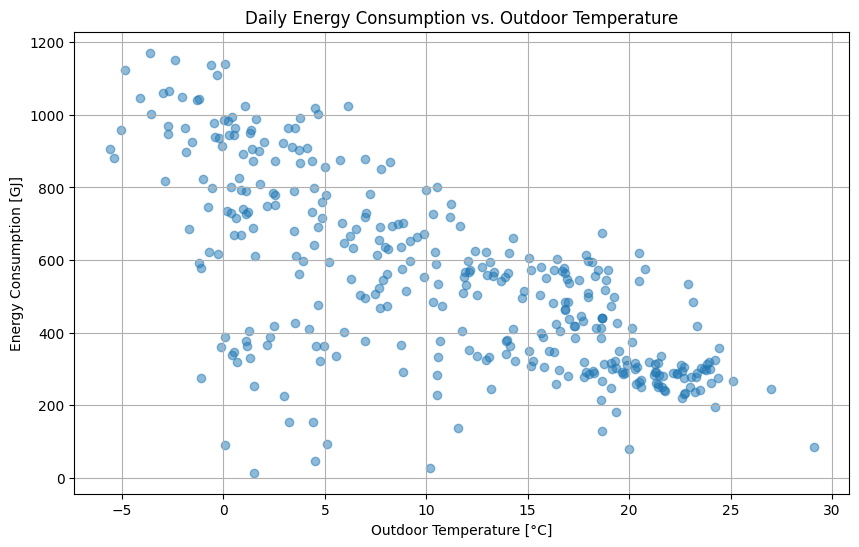

In [ ]:
# Scatter plot with labels and title
plt.figure(figsize=(10, 6))
plt.scatter(daily_data["temp"], daily_data["energy"], alpha=0.5)
plt.title("Daily Energy Consumption vs. Outdoor Temperature")
plt.xlabel("Outdoor Temperature [°C]")
plt.ylabel("Energy Consumption [GJ]")
plt.grid(True)
plt.show()

The plot shows much more linear relationship between temperature and energy usage than in case of hourly data.

In [ ]:
# Calculate Pearson correlation between daily energy consumption and daily average temperature
hourly_pearson = data['energy'].corr(data['temp'], method='pearson')
daily_pearson = daily_data['energy'].corr(daily_data['temp'], method='pearson')
hourly_pearson, daily_pearson

(np.float64(-0.6501640096162927), np.float64(-0.68566935224031))

In [ ]:
# Calculate Spearman correlation between daily energy consumption and daily average temperature
hourly_spearman = data['energy'].corr(data['temp'], method='spearman')
daily_spearman = daily_data['energy'].corr(daily_data['temp'], method='spearman')
hourly_spearman, daily_spearman

(np.float64(-0.6749867635816743), np.float64(-0.692849227298519))

Slightly higher correaltion coefficients in daily data. The data is less differenced and has less of noise.

In [ ]:
# Descriptive statistics summary for the dataset
daily_data.describe()

energy        temp
count   355.000000  355.000000
mean    541.678873   10.867178
std     254.256196    8.409874
min      14.000000   -5.612500
25%     319.000000    3.305682
50%     517.000000   11.145833
75%     717.000000   18.520833
max    1171.000000   29.125000

The descriptive statistics confirm the earlier correlation-based observations:
both temperature and energy consumption appear to be evenly distributed.
The mean and median values are fairly close to each other,
and the 25th and 75th percentiles are symmetrically distributed around the median.

In [ ]:
# Highest energy consumption values and their corresponding temperatures
daily_data_sorted = daily_data.sort_values(by=['energy'], ascending=False)
print(daily_data_sorted.head(10))

            energy      temp
date                        
2025-01-04  1171.0 -3.600000
2024-12-26  1152.0 -2.387500
2025-01-03  1139.0  0.058333
2025-01-11  1136.0 -0.595833
2025-01-05  1123.0 -4.879167
2025-01-12  1111.0 -0.300000
2025-02-19  1065.0 -2.662500
2025-01-20  1061.0 -2.975000
2025-01-14  1049.0 -2.025000
2025-02-11  1045.0 -4.116667


The highest energy consumption values are associated with low temperatures —
all corresponding temperature readings fall within the first quartile.
This observation is consistent with the overall trend identified earlier.

In [ ]:
# Highest temperatures and their corresponding energy consumption values
daily_data_sorted = daily_data.sort_values(by=['temp'], ascending=False)
print(daily_data_sorted.head(10))

            energy       temp
date                         
2024-06-30    86.0  29.125000
2024-07-10   244.0  27.010000
2024-06-29   267.0  25.104167
2024-08-25   358.0  24.452381
2024-06-19   275.0  24.370833
2024-07-12   324.0  24.237500
2024-07-20   195.0  24.213333
2024-07-22   261.0  24.030000
2024-07-09   300.0  23.970833
2024-07-13   319.0  23.933333


The highest temperatures are associated with low energy consumption —
all but one of the corresponding values fall within the first quartile of energy usage.
This is consistent with the overall inverse trend observed earlier.

In [ ]:
# Lowest temperatures and their corresponding energy consumption values
daily_data_sorted = daily_data.sort_values(by=['temp'], ascending=True)
print(daily_data_sorted.head(10))

            energy      temp
date                        
2025-02-17   907.0 -5.612500
2025-02-18   880.0 -5.404167
2025-02-16   958.0 -5.062500
2025-01-05  1123.0 -4.879167
2025-02-11  1045.0 -4.116667
2025-01-04  1171.0 -3.600000
2025-02-20  1003.0 -3.566667
2025-01-20  1061.0 -2.975000
2025-02-10   817.0 -2.858333
2025-02-15   948.0 -2.758333


The lowest temperatures are associated with high energy consumption —
all corresponding values fall within the fourth quartile of energy usage.
This aligns with the overall inverse relationship observed between temperature and consumption.

In [ ]:
#Lowest energy consumption values and their corresponding temperatures
daily_data_sorted = daily_data.sort_values(by=['energy'], ascending=True)
print(daily_data_sorted.head(10))

            energy       temp
date                         
2024-11-25    14.0   1.500000
2024-10-28    27.0  10.200000
2024-11-04    46.0   4.533333
2024-07-01    80.0  20.014286
2024-06-30    86.0  29.125000
2024-11-27    89.0   0.085714
2024-11-07    94.0   5.128571
2024-07-28   130.0  18.680000
2024-10-31   136.0  11.577778
2024-11-18   153.0   3.236364


In the subset with the lowest energy consumption values, temperature readings appear quite random.
This suggests that removing the lower range of energy data was not sufficient to isolate only meaningful observations.
Some noise or irrelevant data may still remain in the dataset.

In [ ]:
# Histogram of daily energy consumption values
sns.displot(daily_data['energy'])

The distribution of daily energy consumption is still non-Gaussian, but "more Gaussian" than hourly consumption.

In [ ]:
# Pearson correlation significance test
corr, p_value = pearsonr(daily_data['temp'], daily_data['energy'])
print(f"The Pearson correlation coefficient is: {corr}")
print(f"The p-value of the test is: {p_value}")

The Pearson correlation coefficient is: -0.6856693522403101
The p-value of the test is: 1.2715889292026351e-50


In [ ]:
# Spearman correlation significance test
spearman_corr, spearman_p_value = spearmanr(daily_data['temp'], daily_data['energy'])
print(f"The Spearman correlation coefficient is: {spearman_corr}")
print(f"The p-value of the test is: {spearman_p_value}")

The Spearman correlation coefficient is: -0.6928492272985189
The p-value of the test is: 4.513122304640298e-52


P-value score indicates that analysis result is statistically relevant.

In [ ]:
daily_data

energy       temp
date                         
2024-03-17   667.0   6.262500
2024-03-18   809.0   1.808333
2024-03-19   681.0   3.486364
2024-03-20   779.0   5.070833
2024-03-21   614.0   7.558333
...            ...        ...
2025-03-11   473.0  10.770833
2025-03-12   622.0  10.416667
2025-03-13   702.0   8.875000
2025-03-14   991.0   3.762500
2025-03-15   963.0   3.175000

[355 rows x 2 columns]

In [ ]:
# Resetting the index
daily_data = daily_data.reset_index()

# Modeling and forecasting

<Axes: xlabel='date'>

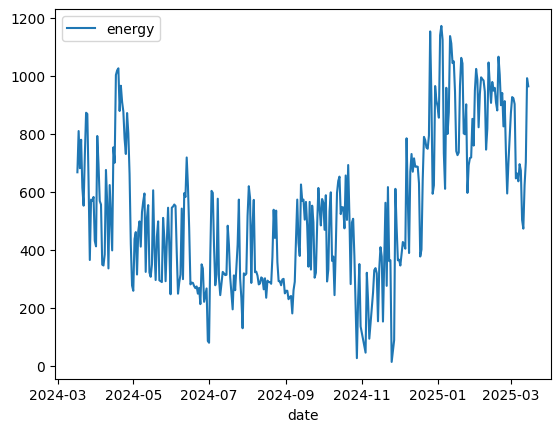

In [ ]:
# Line plot showing energy consumption over time throughout the year
daily_data.plot(kind="line", x="date", y="energy")

Interesting drop of energy consumption in November 2024, could be due to missing data. Besides that, energy usage is fairly corresponded with year's seasons.

In [ ]:
# Checking amount of data points in the dataset
len(daily_data)

355

In [ ]:
# Split the dataset into training and test sets
daily_data_train = daily_data[:-55]
daily_data_test = daily_data[-55:]

In [ ]:
print(f'The training set contains {len(daily_data_train)} records')
print(f'The test set contains {len(daily_data_test)} records')


The training set contains 300 records
The test set contains 55 records


In [ ]:
# Perform ADF test on the energy consumption data
adf_test(daily_data_train['energy'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.325346
p-value                   0.163924
# lags used               6.000000
# observations          293.000000
critical value (1%)      -3.452867
critical value (5%)      -2.871455
critical value (10%)     -2.572053
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
The data has a unit root and is non-stationary


In [ ]:
# Data differentiation
daily_data['energy_diff'] = daily_data['energy'].diff().dropna()
daily_data

date  energy       temp  energy_diff
0    2024-03-17   667.0   6.262500          NaN
1    2024-03-18   809.0   1.808333        142.0
2    2024-03-19   681.0   3.486364       -128.0
3    2024-03-20   779.0   5.070833         98.0
4    2024-03-21   614.0   7.558333       -165.0
..          ...     ...        ...          ...
350  2025-03-11   473.0  10.770833        -30.0
351  2025-03-12   622.0  10.416667        149.0
352  2025-03-13   702.0   8.875000         80.0
353  2025-03-14   991.0   3.762500        289.0
354  2025-03-15   963.0   3.175000        -28.0

[355 rows x 4 columns]

In [ ]:
# Splitting the data into train set and test set
daily_train = daily_data[:-55]
daily_test = daily_data[-55:]

<Axes: >

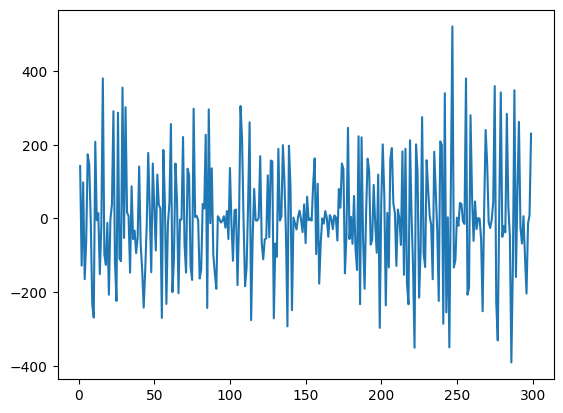

In [ ]:
# Plotting the differenced data
daily_train['energy_diff'].plot()

In [ ]:
# Perform ADF test on the energy consumption differenced data
adf_test(daily_train['energy_diff'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.022819e+01
p-value                 5.110793e-18
# lags used             5.000000e+00
# observations          2.930000e+02
critical value (1%)    -3.452867e+00
critical value (5%)    -2.871455e+00
critical value (10%)   -2.572053e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
The data does not have a unit root and is stationary


In [ ]:
# Fit ARIMA model (p=0, d=1, q=2) to training data and make predictions on the test set
model_e_daily = sm.tsa.arima.ARIMA(daily_train['energy'], order=(0, 1, 2))
results_e_daily = model_e.fit()
predictions_e_daily = results_e_daily.predict(start=daily_test.index[0], end=daily_test.index[-1])
print(results_e_daily.summary())
print(predictions_e_daily)

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                 7597
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -17291.471
Date:                Fri, 04 Jul 2025   AIC                          34588.943
Time:                        07:49:58   BIC                          34609.749
Sample:                             0   HQIC                         34596.083
                               - 7597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0714      0.006    -11.957      0.000      -0.083      -0.060
ma.L2         -0.0556      0.009     -6.435      0.000      -0.072      -0.039
sigma2         5.5560      0.033    169.201      0.0

Constant values along the whole predictions dataset. Model is not working well in this case.

In [ ]:
# Fit SARIMAX model (with temperature as exogenous variable) to training data and make predictions
model_e_t_daily = sm.tsa.arima.ARIMA(endog=daily_train['energy'], exog=daily_train['temp'], order=(0, 1, 2))
results_e_t_daily = model_e_t_daily.fit()
predictions_e_t_daily = results_e_t_daily.predict(start=daily_test.index[0], end=daily_test.index[-1], exog=daily_test[['temp']])
print(results_e_t_daily.summary())
print(predictions_e_t_daily)

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                  300
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1872.709
Date:                Fri, 04 Jul 2025   AIC                           3753.418
Time:                        07:49:59   BIC                           3768.220
Sample:                             0   HQIC                          3759.343
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp         -23.0844      2.784     -8.293      0.000     -28.540     -17.629
ma.L1         -0.4802      0.058     -8.226      0.000      -0.595      -0.366
ma.L2         -0.2748      0.054     -5.134      0.0

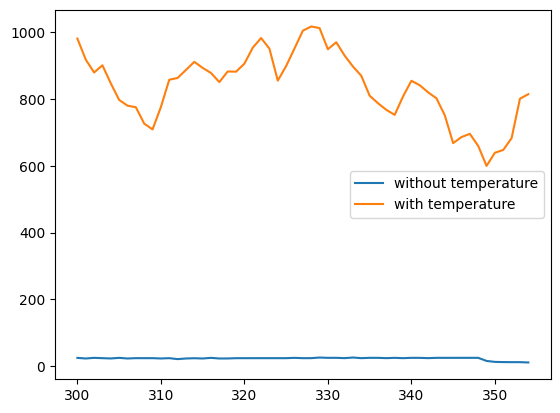

In [ ]:
# Plot daily predictions based on the time series alone vs. with temperature as an exogenous variable
plt.plot(predictions_e_daily, label='without temperature')
plt.plot(predictions_e_t_daily, label='with temperature')
plt.legend()
plt.show()

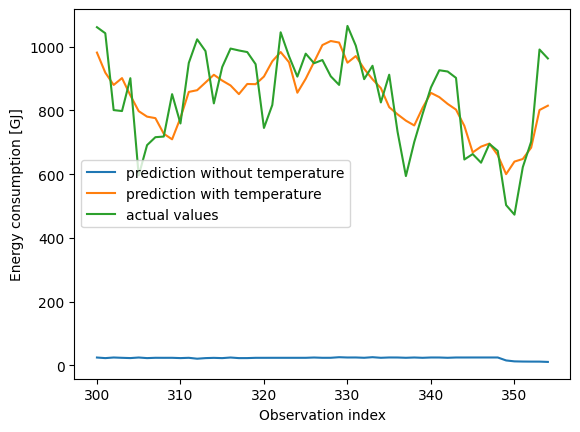

In [ ]:
# Predictions vs. actual energy consumption values
plt.plot(predictions_e_daily, label='prediction without temperature')
plt.plot(predictions_e_t_daily, label='prediction with temperature')
plt.plot(daily_test['energy'], label='actual values')
plt.ylabel('Energy consumption [GJ]')
plt.xlabel('Observation index')
plt.legend()
plt.show()

In [ ]:
# Model accuracy

score_sarimax = np.sqrt(mean_squared_error(daily_test['energy'], predictions_e_t_daily))
print(f'The RMSE of the SARIMAX model (with temperature) on the test set is: {score_sarimax}')

The RMSE of the SARIMAX model (with temperature) on the test set is: 95.99582265480714


The plots above show that predictions incorporating temperature as an exogenous variable
are more accurate than those generated without it. This improvement is due to the model’s ability
to capture the correlation between temperature and energy consumption,
which reflects in daily fluctuations in the forecasted values.

However, prediction series without temperature tend to hover closely around the mean and median,
and do not fully capture the variability observed in the actual test data. The prediction with temeprature follows the pattern of observed, real data but the RMSE is still high and predicted data are not aligned fully with real data.

ARIMA models are generally not ideal for forecasting highly volatile or high-variance time series,
as they primarily model the mean of the data rather than its variance.
In cases where data exhibits high variability, the variance is not constant —
a condition known as heteroskedasticity — which violates one of the key assumptions of the ARIMA framework.

# Machine learning with multiple features for daily data

In [ ]:
# Display the dataset
daily_data

date  energy       temp  energy_diff
0    2024-03-17   667.0   6.262500          NaN
1    2024-03-18   809.0   1.808333        142.0
2    2024-03-19   681.0   3.486364       -128.0
3    2024-03-20   779.0   5.070833         98.0
4    2024-03-21   614.0   7.558333       -165.0
..          ...     ...        ...          ...
350  2025-03-11   473.0  10.770833        -30.0
351  2025-03-12   622.0  10.416667        149.0
352  2025-03-13   702.0   8.875000         80.0
353  2025-03-14   991.0   3.762500        289.0
354  2025-03-15   963.0   3.175000        -28.0

[355 rows x 4 columns]

In [ ]:
# Dropping 'energy_diff' column
daily_train = daily_train.drop('energy_diff', axis=1)

In [ ]:
# Set 'time' column as the index
daily_train.set_index('date', inplace=True)

In [ ]:
# Display the final train dataset used for modeling
daily_train

energy      temp
date                        
2024-03-17   667.0  6.262500
2024-03-18   809.0  1.808333
2024-03-19   681.0  3.486364
2024-03-20   779.0  5.070833
2024-03-21   614.0  7.558333
...            ...       ...
2025-01-15   944.0  0.495833
2025-01-16   740.0  0.950000
2025-01-17   726.0  1.104167
2025-01-18   735.0  0.158333
2025-01-19   965.0 -1.900000

[300 rows x 2 columns]

In [ ]:
# Dropping the 'energy_diff' column
daily_test = daily_test.drop('energy_diff', axis=1)


In [ ]:
# Set the index to date data
daily_test = daily_test.set_index('date')

In [ ]:
# Display the final test dataset used for modeling
daily_test

energy       temp
date                         
2025-01-20  1061.0  -2.975000
2025-01-21  1042.0  -1.316667
2025-01-22   801.0   0.358333
2025-01-23   798.0  -0.575000
2025-01-24   901.0   1.770833
2025-01-25   596.0   3.918182
2025-01-26   691.0   4.662500
2025-01-27   716.0   4.866667
2025-01-28   718.0   6.987500
2025-01-29   851.0   7.745833
2025-01-30   759.0   4.837500
2025-01-31   949.0   1.304167
2025-02-01  1023.0   1.070833
2025-02-02   986.0   0.025000
2025-02-03   822.0  -1.025000
2025-02-04   936.0  -0.237500
2025-02-05   994.0   0.425000
2025-02-06   988.0   1.604167
2025-02-07   983.0   0.225000
2025-02-08   945.0   0.254167
2025-02-09   745.0  -0.786364
2025-02-10   817.0  -2.858333
2025-02-11  1045.0  -4.116667
2025-02-12   970.0  -2.729167
2025-02-13   906.0   1.413636
2025-02-14   978.0  -0.479167
2025-02-15   948.0  -2.758333
2025-02-16   958.0  -5.062500
2025-02-17   907.0  -5.612500
2025-02-18   880.0  -5.404167
2025-02-19  1065.0  -2.662500
2025-02-20  1003.0  -3.566667
2025-02-21   898.0  -1.837500
2025-02-22   940.0  -0.416667
2025-02-23   825.0   0.787500
2025-02-24   912.0   3.375000
2025-02-25   733.0   4.350000
2025-02-26   594.0   5.208333
2025-02-27   701.0   5.858333
2025-02-28   789.0   3.466667
2025-03-01   872.0   1.433333
2025-03-02   926.0   2.012500
2025-03-03   922.0   2.933333
2025-03-04   902.0   3.708333
2025-03-05   646.0   5.920833
2025-03-06   663.0   9.525000
2025-03-07   636.0   8.737500
2025-03-08   695.0   8.320833
2025-03-09   673.0   9.883333
2025-03-10   503.0  12.479167
2025-03-11   473.0  10.770833
2025-03-12   622.0  10.416667
2025-03-13   702.0   8.875000
2025-03-14   991.0   3.762500
2025-03-15   963.0   3.175000

In [ ]:
# Change index to datetime format
daily_data.index = daily_data.index.astype('datetime64[ns]')

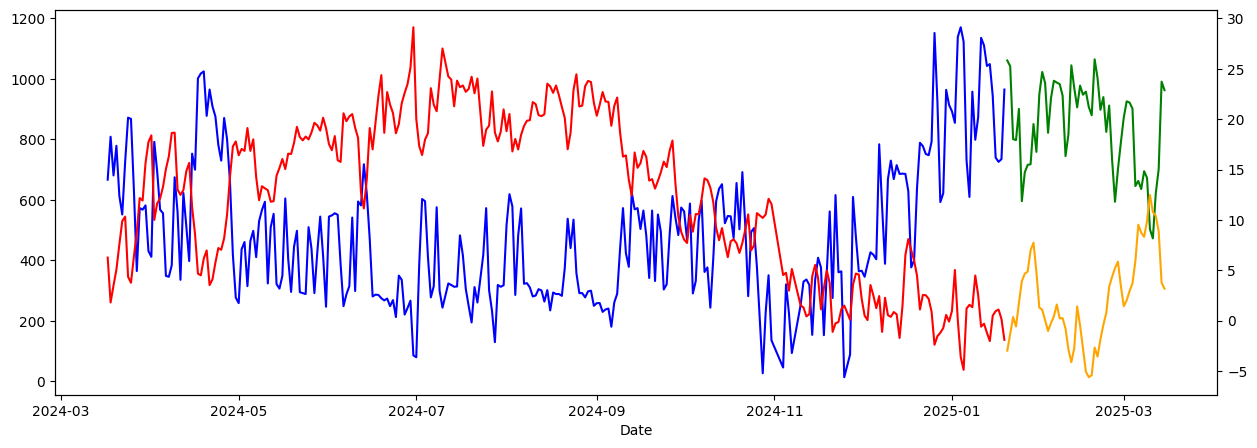

In [ ]:
# Visualize training and test datasets
fig, ax1 = plt.subplots(figsize=(15, 5))
daily_train['energy'].plot(ax=ax1, label='training', color = 'blue')
daily_test['energy'].plot(ax=ax1, label='test', color = 'green')
ax2 = ax1.twinx()
daily_train['temp'].plot(ax=ax2, label='training', color = 'red')
daily_test['temp'].plot(ax=ax2, label='test', color = 'orange')
ax1.set_xlabel('Date')
ax.legend()
plt.show()

In [ ]:
def create_features_daily(data):
    """
    Feature engineering function:
    Generates time-based, lagged, and rolling features
    for temperature and energy consumption to support predictive modeling.
    """
    # Rolling averages of temperature
    data['temp_MA_7'] = data['temp'].rolling(window=7).mean()
    data['temp_MA_14'] = data['temp'].rolling(window=14).mean()
    data['temp_MA_21'] = data['temp'].rolling(window=21).mean()

    # Rolling averages of energy consumption
    data['energy_MA_7'] = data['energy'].rolling(window=7).mean()
    data['energy_MA_14'] = data['energy'].rolling(window=14).mean()
    data['energy_MA_21'] = data['energy'].rolling(window=21).mean()

    # First-order differences
    data['temp_diff'] = data['temp'].diff()
    data['energy_diff'] = data['energy'].diff()

    # Time-based calendar features
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Lag features for past temperature and energy values (1 to 30 steps)
    lags = list(range(1, 31))
    for i in lags:
        data[f'temp_lag_{i}'] = data['temp'].shift(i)
        data[f'energy_lag_{i}'] = data['energy'].shift(i)

    return data

In [ ]:
# Apply the feature engineering function to the dataset
daily_final = create_features_daily(daily_data)

In [ ]:
# Display the list of columns in the new feature-enhanced dataset
daily_final.columns

Index(['date', 'energy', 'temp', 'energy_diff', 'temp_MA_7', 'temp_MA_14',
       'temp_MA_21', 'energy_MA_7', 'energy_MA_14', 'energy_MA_21',
       'temp_diff', 'dayofweek', 'dayofyear', 'quarter', 'month', 'year',
       'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23'

# Model selection: XGBoost

We selected XGBoost as the modeling algorithm due to its efficiency and flexibility as a gradient boosting implementation for regression tasks.
Although it is not inherently designed for time series forecasting, it can be effectively applied to such problems
by transforming the data into a supervised learning format.

This approach requires creating time-based features such as lags, rolling averages, and calendar features,
allowing the model to learn from past observations to predict future values.

In [ ]:
# Change training and test datasets indexes to datetime format
daily_train.index = daily_train.index.astype('datetime64[ns]')
daily_test.index = daily_test.index.astype('datetime64[ns]')

In [ ]:
# Apply the feature engineering function to training and test datasets
daily_train_final = create_features(daily_train)
daily_test_final = create_features(daily_test)

In [ ]:
# Display the column names for feature selection
daily_train_final.columns


Index(['energy', 'temp', 'temp_MA_7', 'temp_MA_14', 'temp_MA_21',
       'energy_MA_7', 'energy_MA_14', 'energy_MA_21', 'temp_diff',
       'energy_diff', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year', 'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23'

In [ ]:
# Define training and test feature sets for the model

FEATURES_DAILY = ['temp', 'temp_MA_7', 'temp_MA_14', 'temp_MA_21',
       'energy_MA_7', 'energy_MA_14', 'energy_MA_21', 'temp_diff',
       'energy_diff', 'dayofweek', 'dayofyear', 'quarter', 'month',
       'year', 'temp_lag_1', 'energy_lag_1', 'temp_lag_2', 'energy_lag_2',
       'temp_lag_3', 'energy_lag_3', 'temp_lag_4', 'energy_lag_4',
       'temp_lag_5', 'energy_lag_5', 'temp_lag_6', 'energy_lag_6',
       'temp_lag_7', 'energy_lag_7', 'temp_lag_8', 'energy_lag_8',
       'temp_lag_9', 'energy_lag_9', 'temp_lag_10', 'energy_lag_10',
       'temp_lag_11', 'energy_lag_11', 'temp_lag_12', 'energy_lag_12',
       'temp_lag_13', 'energy_lag_13', 'temp_lag_14', 'energy_lag_14',
       'temp_lag_15', 'energy_lag_15', 'temp_lag_16', 'energy_lag_16',
       'temp_lag_17', 'energy_lag_17', 'temp_lag_18', 'energy_lag_18',
       'temp_lag_19', 'energy_lag_19', 'temp_lag_20', 'energy_lag_20',
       'temp_lag_21', 'energy_lag_21', 'temp_lag_22', 'energy_lag_22',
       'temp_lag_23', 'energy_lag_23', 'temp_lag_24', 'energy_lag_24',
       'temp_lag_25', 'energy_lag_25', 'temp_lag_26', 'energy_lag_26',
       'temp_lag_27', 'energy_lag_27', 'temp_lag_28', 'energy_lag_28',
       'temp_lag_29', 'energy_lag_29', 'temp_lag_30', 'energy_lag_30']

TARGET_DAILY = 'energy'

In [ ]:
# Define training and test sets for the model

X_train = daily_train_final[FEATURES_DAILY]
y_train = daily_train_final[TARGET_DAILY]

X_test = daily_test_final[FEATURES_DAILY]
y_test = daily_test_final[TARGET_DAILY]

In [ ]:
# Create XGBoost regression model with same parameters as with the hourly data
reg = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=50, learning_rate=0.02)

# Train the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:225.19404	validation_1-rmse:381.97988
[1]	validation_0-rmse:221.23469	validation_1-rmse:377.83284
[2]	validation_0-rmse:217.34978	validation_1-rmse:373.76415
[3]	validation_0-rmse:213.54270	validation_1-rmse:369.77872
[4]	validation_0-rmse:209.80082	validation_1-rmse:364.03436
[5]	validation_0-rmse:206.13867	validation_1-rmse:360.20461
[6]	validation_0-rmse:202.54185	validation_1-rmse:354.69619
[7]	validation_0-rmse:199.01479	validation_1-rmse:349.30971
[8]	validation_0-rmse:195.55767	validation_1-rmse:344.07662
[9]	validation_0-rmse:192.16737	validation_1-rmse:338.95713
[10]	validation_0-rmse:188.84563	validation_1-rmse:335.49199
[11]	validation_0-rmse:185.58137	validation_1-rmse:330.58247
[12]	validation_0-rmse:182.38129	validation_1-rmse:325.75115
[13]	validation_0-rmse:179.24165	validation_1-rmse:321.05702
[14]	validation_0-rmse:176.15992	validation_1-rmse:316.45316
[15]	validation_0-rmse:173.13151	validation_1-rmse:311.91809
[16]	validation_0-rmse:170.16676	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

By setting a low learning rate (0.001) and a high number of trees (5000), the model avoids overfitting and converges gradually, resulting in predictions with a very low root mean squared error (RMSE).

However, the final RMSE for daily data (5.30) is still significantly higher than for the hourly data (0.14), despite using the same model parameters. This difference is expected, as the daily values are aggregated from hourly data and thus are approximately 24 times higher in magnitude.

When the relative error is considered, the RMSE for daily predictions is only about 2 times higher, which is acceptable and reflects the increased complexity of the aggregated prediction task.

In [ ]:
# Create XGBoost regression model with 10 000 iterations
reg = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=50, learning_rate=0.001)

# Train the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
[2753]	validation_0-rmse:23.72047	validation_1-rmse:116.44137
[2754]	validation_0-rmse:23.70242	validation_1-rmse:116.43107
[2755]	validation_0-rmse:23.68450	validation_1-rmse:116.41871
[2756]	validation_0-rmse:23.66615	validation_1-rmse:116.40640
[2757]	validation_0-rmse:23.64827	validation_1-rmse:116.39407
[2758]	validation_0-rmse:23.63028	validation_1-rmse:116.38381
[2759]	validation_0-rmse:23.61198	validation_1-rmse:116.37222
[2760]	validation_0-rmse:23.59415	validation_1-rmse:116.35994
[2761]	validation_0-rmse:23.57630	validation_1-rmse:116.34993
[2762]	validation_0-rmse:23.55837	validation_1-rmse:116.33972
[2763]	validation_0-rmse:23.54013	validation_1-rmse:116.32865
[2764]	validation_0-rmse:23.52224	validation_1-rmse:116.31847
[2765]	validation_0-rmse:23.50447	validation_1-rmse:116.30852
[2766]	validation_0-rmse:23.48627	validation_1-rmse:116.29638
[2767]	validation_0-rmse:23.46843	validation_1-rmse:116.28624
[2768

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Early stopping results in 1,71 as final RSME. This means that we get smaller relative error than for the hourly data predictions.

In [ ]:
# feature importances table creation for the 5k iterations
fi_daily_5000 = pd.DataFrame(data = reg.feature_importances_, index = FEATURES_DAILY, columns = ['importance'])

In [ ]:
# feature importances display
fi_daily_5000

importance
temp             0.014982
temp_MA_7        0.009995
temp_MA_14       0.000826
temp_MA_21       0.002267
energy_MA_7      0.283072
...                   ...
energy_lag_28    0.003388
temp_lag_29      0.010222
energy_lag_29    0.042253
temp_lag_30      0.001951
energy_lag_30    0.002551

[74 rows x 1 columns]

In [ ]:
# top 10 most important features for 5k iterations

fi_daily_5000.sort_values('importance', ascending=False).head(10).plot(kind='barh', title='Feature Importance')

<Axes: title={'center': 'Feature Importance'}>

Training on daily data we get more of important features, with energy consumption 7 days moving average and one-day energy lag (as with the hourly data it was one-hour) standing out.

# Predictions on the test set for the daily data

In [ ]:
# Add predicted values to the test DataFrame
daily_test_final['prediction_xgb'] = reg.predict(X_test)
daily_test_final['prediction_sarimax'] = predictions_e_t_daily.values

In [ ]:
# Display the test dataset with added predicted energy consumption values
daily_test_final

energy       temp  temp_MA_7  temp_MA_14  temp_MA_21  energy_MA_7  \
date                                                                            
2025-01-20  1061.0  -2.975000        NaN         NaN         NaN          NaN   
2025-01-21  1042.0  -1.316667        NaN         NaN         NaN          NaN   
2025-01-22   801.0   0.358333        NaN         NaN         NaN          NaN   
2025-01-23   798.0  -0.575000        NaN         NaN         NaN          NaN   
2025-01-24   901.0   1.770833        NaN         NaN         NaN          NaN   
2025-01-25   596.0   3.918182        NaN         NaN         NaN          NaN   
2025-01-26   691.0   4.662500   0.834740         NaN         NaN   841.428571   
2025-01-27   716.0   4.866667   1.954978         NaN         NaN   792.142857   
2025-01-28   718.0   6.987500   3.141288         NaN         NaN   745.857143   
2025-01-29   851.0   7.745833   4.196645         NaN         NaN   753.000000   
2025-01-30   759.0   4.837500   4.969859         NaN         NaN   747.428571   
2025-01-31   949.0   1.304167   4.903193         NaN         NaN   754.285714   
2025-02-01  1023.0   1.070833   4.496429         NaN         NaN   815.285714   
2025-02-02   986.0   0.025000   3.833929    2.334334         NaN   857.428571   
2025-02-03   822.0  -1.025000   2.992262    2.473620         NaN   872.571429   
2025-02-04   936.0  -0.237500   1.960119    2.550703         NaN   903.714286   
2025-02-05   994.0   0.425000   0.914286    2.555465         NaN   924.142857   
2025-02-06   988.0   1.604167   0.452381    2.711120         NaN   956.857143   
2025-02-07   983.0   0.225000   0.298214    2.600703         NaN   961.714286   
2025-02-08   945.0   0.254167   0.181548    2.338988         NaN   950.571429   
2025-02-09   745.0  -0.786364   0.065639    1.949784    1.578102   916.142857   
2025-02-10   817.0  -2.858333  -0.196266    1.397998    1.583658   915.428571   
2025-02-11  1045.0  -4.116667  -0.750433    0.604843    1.450325   931.000000   
2025-02-12   970.0  -2.729167  -1.201028   -0.143371    1.303301   927.571429   
2025-02-13   906.0   1.413636  -1.228247   -0.387933    1.397998   915.857143   
2025-02-14   978.0  -0.479167  -1.328842   -0.515314    1.290855   915.142857   
2025-02-15   948.0  -2.758333  -1.759199   -0.788826    0.972926   915.571429   
2025-02-16   958.0  -5.062500  -2.370076   -1.152219    0.509830   946.000000   
2025-02-17   907.0  -5.612500  -2.763528   -1.479897    0.010823   958.857143   
2025-02-18   880.0  -5.404167  -2.947457   -1.848945   -0.579257   935.285714   
2025-02-19  1065.0  -2.662500  -2.937933   -2.069481   -1.074892   948.857143   
2025-02-20  1003.0  -3.566667  -3.649405   -2.438826   -1.475090   962.714286   
2025-02-21   898.0  -1.837500  -3.843452   -2.586147   -1.624693   951.285714   
2025-02-22   940.0  -0.416667  -3.508929   -2.634064   -1.695527   950.142857   
2025-02-23   825.0   0.787500  -2.673214   -2.521645   -1.659217   931.142857   
2025-02-24   912.0   3.375000  -1.389286   -2.076407   -1.449693   931.857143   
2025-02-25   733.0   4.350000   0.004167   -1.471645   -1.231241   910.857143   
2025-02-26   594.0   5.208333   1.128571   -0.904681   -1.003463   843.571429   
2025-02-27   701.0   5.858333   2.475000   -0.587202   -0.800884   800.428571   
2025-02-28   789.0   3.466667   3.232738   -0.305357   -0.646519   784.857143   
2025-03-01   872.0   1.433333   3.497024   -0.005952   -0.590368   775.142857   
2025-03-02   926.0   2.012500   3.672024    0.499405   -0.457089   789.571429   
2025-03-03   922.0   2.933333   3.608929    1.109821   -0.181295   791.000000   
2025-03-04   902.0   3.708333   3.517262    1.760714    0.191324   815.142857   
2025-03-05   646.0   5.920833   3.619048    2.373810    0.603229   822.571429   
2025-03-06   663.0   9.525000   4.142857    3.308929    0.989484   817.142857   
2025-03-07   636.0   8.737500   4.895833    4.064286    1.428373   795.285714   
2025-03-08   695.0   8.320833   5.879762   

In [ ]:
# Merge original dataset with predictions
daily_data_pred = daily_final.merge(daily_test_final[['prediction_xgb', 'prediction_sarimax']], how='left', left_index=True, right_index=True)

In [ ]:
# Plot actual energy data with model predictions over the full time range and save the plot as png

ax = daily_data_pred[['energy']].plot(figsize=(15, 5))
daily_data_pred['prediction_xgb'].plot(ax=ax)
daily_data_pred['prediction_sarimax'].plot(ax=ax)
plt.legend(['Actual energy consumption', 'Model prediction_XGBoost', 'Model prediction_SARIMAX'])
ax.set_title('Actual vs Predicted Energy Consumption')
plt.savefig('actual_vs_predicted_full_daily.png')
plt.show()

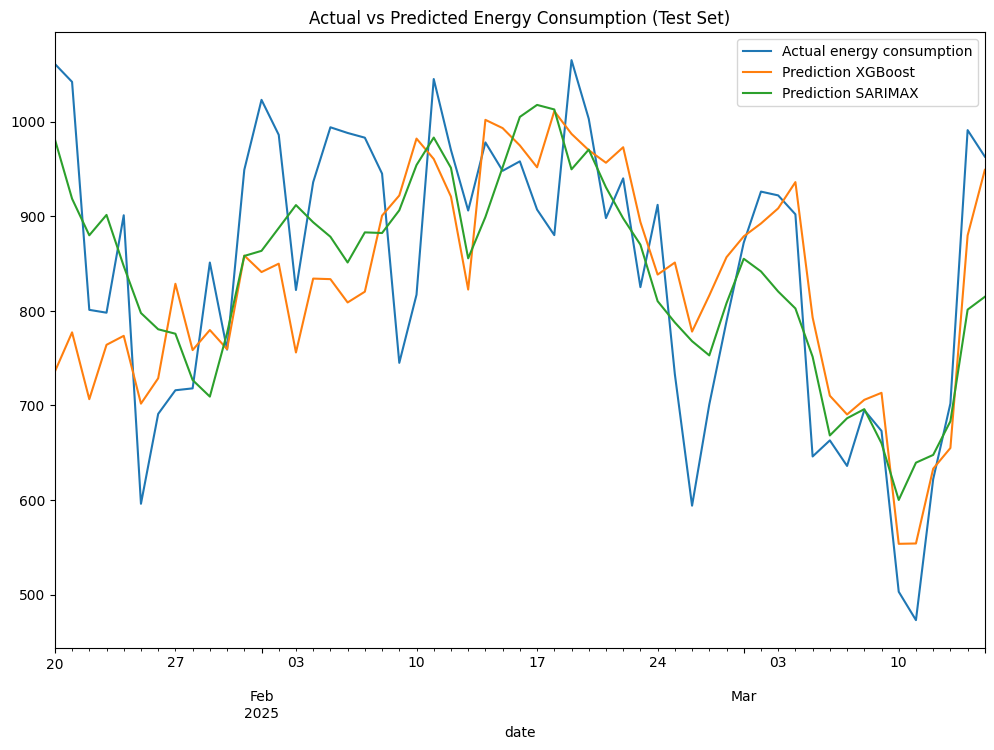

In [ ]:
# Plot actual vs predicted energy consumption on the test dataset and save the plot as png

ax = daily_test_final[['energy', 'prediction_xgb', 'prediction_sarimax']].plot(figsize=(12, 8))
plt.legend(['Actual energy consumption', 'Prediction XGBoost', 'Prediction SARIMAX'])
ax.set_title('Actual vs Predicted Energy Consumption (Test Set)')
plt.savefig('actual_vs_predicted_test_daily.png')
plt.show()

In [ ]:
# Model accuracy – XGBoost
score_xgb = np.sqrt(mean_squared_error(daily_test_final['energy'], daily_test_final['prediction_xgb']))
print(f'RMSE on the test set for the XGBoost model: {score_xgb}')

RMSE on the test set for the XGBoost model: 107.45552399816388


In [ ]:
# Model accuracy – SARIMAX
score_sarimax = np.sqrt(mean_squared_error(daily_test_final['energy'], daily_test_final['prediction_sarimax']))
print(f'RMSE on the test set for the XGBoost model: {score_sarimax}')

RMSE on the test set for the XGBoost model: 95.99582265480714


On such aggregated data (only 300 data points in training set) SARIMAX model performs slightly better than XGBoost, but both of approaches have poor accuracy compared to XGBoost model fed hourly data. This is probably due to coarse aggregation. It is not a model failure, but data quality constraint.

Despite extensive tuning and the use of advanced models (e.g. XGBoost), the prediction error for daily energy consumption remains significantly higher than expected.
This suggests that daily-level data may be insufficient to accurately model the underlying dynamics of energy usage, especially when critical process variations (e.g. shift patterns, material types, or operational events) are lost due to aggregation.
More granular data (e.g. hourly or per-batch) would likely enable better predictive performance by capturing short-term fluctuations and process-specific signals.

# Main problem: model predicts very well on hourly data, but we would like to know the energy usage more than hour into the future. Right now the model has access to the energy_lag_1 data (which is energy consumption for the previous hour) and feature importances analysis showed us that this is the most important feature for predictions.
# Most of the planning of energy generation happens on a daily, even weekly basis, not hour to hour, so features have to be adjusted.

In [ ]:
def create_features_24(data):
    """
    Feature engineering function:
    Generates time-based, lagged, and rolling features
    for temperature and energy consumption to support predictive modeling.
    In this case only 24h+ energy lags are available because of the assumption
    that planning takes place one day ahead
    """
    # Rolling averages of temperature (shifted by 24 hours)
    data['temp_MA_7_24'] = data['temp'].rolling(window=7).mean().shift(24)
    data['temp_MA_14_24'] = data['temp'].rolling(window=14).mean().shift(24)
    data['temp_MA_21_24'] = data['temp'].rolling(window=21).mean().shift(24)

    # Rolling averages of energy consumption (shifted by 24 hours)
    data['energy_MA_7_24'] = data['energy'].rolling(window=7).mean().shift(24)
    data['energy_MA_14_24'] = data['energy'].rolling(window=14).mean().shift(24)
    data['energy_MA_21_24'] = data['energy'].rolling(window=21).mean().shift(24)

    # Time-based calendar features
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear'] = data.index.dayofyear
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year

    # Lag features for past temperature and energy values (24 to 71)
    lags = list(range(24, 72))
    for i in lags:
        data[f'temp_lag_{i}'] = data['temp'].shift(i)
        data[f'energy_lag_{i}'] = data['energy'].shift(i)

    return data

In [ ]:
data_24 = create_features_24(df_raw.copy())

/tmp/ipython-input-130-3178352247.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'energy_lag_{i}'] = data['energy'].shift(i)
/tmp/ipython-input-130-3178352247.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'temp_lag_{i}'] = data['temp'].shift(i)
/tmp/ipython-input-130-3178352247.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

In [ ]:
df_raw

temp  energy
time                             
2024-03-16 09:00:00   9.1    26.0
2024-03-16 10:00:00  11.6    26.0
2024-03-16 11:00:00  13.3    26.0
2024-03-16 12:00:00  14.3    25.0
2024-03-16 13:00:00  15.1    25.0
...                   ...     ...
2025-03-16 03:00:00   1.5    39.0
2025-03-16 04:00:00   1.3    39.0
2025-03-16 05:00:00   0.9    38.0
2025-03-16 06:00:00   0.8    35.0
2025-03-16 07:00:00   0.9    37.0

[8097 rows x 2 columns]

In [ ]:
data_24

temp  energy  temp_MA_7_24  temp_MA_14_24  temp_MA_21_24  \
time                                                                            
2024-03-16 09:00:00   9.1    26.0           NaN            NaN            NaN   
2024-03-16 10:00:00  11.6    26.0           NaN            NaN            NaN   
2024-03-16 11:00:00  13.3    26.0           NaN            NaN            NaN   
2024-03-16 12:00:00  14.3    25.0           NaN            NaN            NaN   
2024-03-16 13:00:00  15.1    25.0           NaN            NaN            NaN   
...                   ...     ...           ...            ...            ...   
2025-03-16 03:00:00   1.5    39.0      2.471429       3.342857       3.528571   
2025-03-16 04:00:00   1.3    39.0      2.371429       3.142857       3.528571   
2025-03-16 05:00:00   0.9    38.0      2.400000       2.992857       3.514286   
2025-03-16 06:00:00   0.8    35.0      2.414286       2.835714       3.471429   
2025-03-16 07:00:00   0.9    37.0      2.485714       2.757143       3.409524   

                     energy_MA_7_24  energy_MA_14_24  energy_MA_21_24  hour  \
time                                                                          
2024-03-16 09:00:00             NaN              NaN              NaN     9   
2024-03-16 10:00:00             NaN              NaN              NaN    10   
2024-03-16 11:00:00             NaN              NaN              NaN    11   
2024-03-16 12:00:00             NaN              NaN              NaN    12   
2024-03-16 13:00:00             NaN              NaN              NaN    13   
...                             ...              ...              ...   ...   
2025-03-16 03:00:00       40.571429        41.142857        41.333333     3   
2025-03-16 04:00:00       40.428571        40.928571        41.142857     4   
2025-03-16 05:00:00       40.428571        40.785714        41.142857     5   
2025-03-16 06:00:00       40.285714        40.714286        41.142857     6   
2025-03-16 07:00:00       40.000000        40.642857        41.000000     7   

                     dayofweek  ...  temp_lag_67  energy_lag_67  temp_lag_68  \
time                            ...                                            
2024-03-16 09:00:00          5  ...          NaN            NaN          NaN   
2024-03-16 10:00:00          5  ...          NaN            NaN          NaN   
2024-03-16 11:00:00          5  ...          NaN            NaN          NaN   
2024-03-16 12:00:00          5  ...          NaN            NaN          NaN   
2024-03-16 13:00:00          5  ...          NaN            NaN          NaN   
...                        ...  ...          ...            ...          ...   
2025-03-16 03:00:00          6  ...         11.0           27.0          9.3   
2025-03-16 04:00:00          6  ...         11.0           26.0         11.0   
2025-03-16 05:00:00          6  ...         11.0           27.0         11.0   
2025-03-16 06:00:00          6  ...         11.0           26.0         11.0   
2025-03-16 07:00:00          6  ...         11.0           26.0         11.0   

                     energy_lag_68  temp_lag_69  energy_lag_69  temp_lag_70  \
time                                                                          
2024-03-16 09:00:00            NaN          NaN            NaN          NaN   
2024-03-16 10:00:00            NaN          NaN            NaN          NaN   
2024-03-16 11:00:00            NaN          NaN            NaN          NaN   
2024-03-16 12:00:00            NaN          NaN            NaN          NaN   
2024-03-16 13:00:00            NaN          NaN            NaN          NaN   
...                            ...          ...            ...          ...   
2025-03-16 03:00:00           27.0         10.0           26.0          9.0   
2025-03-16 04:00:00           27.0          9.3           27.0         10.0   
2025-03-16 05:00:00           26.0         11.0           27.0          9.3   
2025-03-16 06:00:00          

In [ ]:
len(data_24)*0.2

1619.4

In [ ]:
len(data_24)*0.3

2429.1

In [ ]:
# Splitting new df with 0.2 ratio of test data
train_24 = data_24.iloc[:-2630]
val_24 = data_24.iloc[-2630:-1620]
test_24 = data_24.iloc[-1620:]

In [ ]:
print(train_24.columns.tolist())

['temp', 'energy', 'temp_MA_7_24', 'temp_MA_14_24', 'temp_MA_21_24', 'energy_MA_7_24', 'energy_MA_14_24', 'energy_MA_21_24', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month', 'year', 'temp_lag_24', 'energy_lag_24', 'temp_lag_25', 'energy_lag_25', 'temp_lag_26', 'energy_lag_26', 'temp_lag_27', 'energy_lag_27', 'temp_lag_28', 'energy_lag_28', 'temp_lag_29', 'energy_lag_29', 'temp_lag_30', 'energy_lag_30', 'temp_lag_31', 'energy_lag_31', 'temp_lag_32', 'energy_lag_32', 'temp_lag_33', 'energy_lag_33', 'temp_lag_34', 'energy_lag_34', 'temp_lag_35', 'energy_lag_35', 'temp_lag_36', 'energy_lag_36', 'temp_lag_37', 'energy_lag_37', 'temp_lag_38', 'energy_lag_38', 'temp_lag_39', 'energy_lag_39', 'temp_lag_40', 'energy_lag_40', 'temp_lag_41', 'energy_lag_41', 'temp_lag_42', 'energy_lag_42', 'temp_lag_43', 'energy_lag_43', 'temp_lag_44', 'energy_lag_44', 'temp_lag_45', 'energy_lag_45', 'temp_lag_46', 'energy_lag_46', 'temp_lag_47', 'energy_lag_47', 'temp_lag_48', 'energy_lag_48', 'temp_lag_49'

In [ ]:
FEATURES_24 = ['temp_MA_7_24', 'temp_MA_14_24', 'temp_MA_21_24', 'energy_MA_7_24', 'energy_MA_14_24', 'energy_MA_21_24', 'hour', 'dayofweek', 'dayofyear', 'quarter', 'month', 'year', 'temp_lag_24', 'energy_lag_24', 'temp_lag_25', 'energy_lag_25', 'temp_lag_26', 'energy_lag_26', 'temp_lag_27', 'energy_lag_27', 'temp_lag_28', 'energy_lag_28', 'temp_lag_29', 'energy_lag_29', 'temp_lag_30', 'energy_lag_30', 'temp_lag_31', 'energy_lag_31', 'temp_lag_32', 'energy_lag_32', 'temp_lag_33', 'energy_lag_33', 'temp_lag_34', 'energy_lag_34', 'temp_lag_35', 'energy_lag_35', 'temp_lag_36', 'energy_lag_36', 'temp_lag_37', 'energy_lag_37', 'temp_lag_38', 'energy_lag_38', 'temp_lag_39', 'energy_lag_39', 'temp_lag_40', 'energy_lag_40', 'temp_lag_41', 'energy_lag_41', 'temp_lag_42', 'energy_lag_42', 'temp_lag_43', 'energy_lag_43', 'temp_lag_44', 'energy_lag_44', 'temp_lag_45', 'energy_lag_45', 'temp_lag_46', 'energy_lag_46', 'temp_lag_47', 'energy_lag_47', 'temp_lag_48', 'energy_lag_48', 'temp_lag_49', 'energy_lag_49', 'temp_lag_50', 'energy_lag_50', 'temp_lag_51', 'energy_lag_51', 'temp_lag_52', 'energy_lag_52', 'temp_lag_53', 'energy_lag_53', 'temp_lag_54', 'energy_lag_54', 'temp_lag_55', 'energy_lag_55', 'temp_lag_56', 'energy_lag_56', 'temp_lag_57', 'energy_lag_57', 'temp_lag_58', 'energy_lag_58', 'temp_lag_59', 'energy_lag_59', 'temp_lag_60', 'energy_lag_60', 'temp_lag_61', 'energy_lag_61', 'temp_lag_62', 'energy_lag_62', 'temp_lag_63', 'energy_lag_63', 'temp_lag_64', 'energy_lag_64', 'temp_lag_65', 'energy_lag_65', 'temp_lag_66', 'energy_lag_66', 'temp_lag_67', 'energy_lag_67', 'temp_lag_68', 'energy_lag_68', 'temp_lag_69', 'energy_lag_69', 'temp_lag_70', 'energy_lag_70', 'temp_lag_71', 'energy_lag_71']
TARGET_24 = 'energy'

In [ ]:
X_train, y_train = train_24[FEATURES_24], train_24[TARGET_24]
X_val, y_val = val_24[FEATURES_24], val_24[TARGET_24]
X_test, y_test = test_24[FEATURES_24], test_24[TARGET_24]

In [ ]:
# Create XGBoost regression model
reg = xgb.XGBRegressor(n_estimators=5000, early_stopping_rounds=50, learning_rate=0.01)

# Train the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-rmse:8.05847	validation_1-rmse:13.81171
[1]	validation_0-rmse:8.00675	validation_1-rmse:13.79951
[2]	validation_0-rmse:7.95571	validation_1-rmse:13.78643
[3]	validation_0-rmse:7.90535	validation_1-rmse:13.77462
[4]	validation_0-rmse:7.85565	validation_1-rmse:13.76215
[5]	validation_0-rmse:7.80662	validation_1-rmse:13.75167
[6]	validation_0-rmse:7.75796	validation_1-rmse:13.74262
[7]	validation_0-rmse:7.71004	validation_1-rmse:13.72859
[8]	validation_0-rmse:7.66280	validation_1-rmse:13.72527
[9]	validation_0-rmse:7.61605	validation_1-rmse:13.71676
[10]	validation_0-rmse:7.56973	validation_1-rmse:13.70574
[11]	validation_0-rmse:7.52417	validation_1-rmse:13.70435
[12]	validation_0-rmse:7.47908	validation_1-rmse:13.70328
[13]	validation_0-rmse:7.43479	validation_1-rmse:13.70205
[14]	validation_0-rmse:7.39083	validation_1-rmse:13.70111
[15]	validation_0-rmse:7.34726	validation_1-rmse:13.69978
[16]	validation_0-rmse:7.30477	validation_1-rmse:13.70462
[17]	validation_0-rmse:7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature importances

In [ ]:
# feature importances table creation
fe = pd.DataFrame(data = reg.feature_importances_, index = FEATURES_24, columns = ['importance'])

In [ ]:
# feature importnaces display
fe

importance
temp_MA_7_24       0.001978
temp_MA_14_24      0.024439
temp_MA_21_24      0.034347
energy_MA_7_24     0.013414
energy_MA_14_24    0.011421
...                     ...
energy_lag_69      0.014195
temp_lag_70        0.008300
energy_lag_70      0.009910
temp_lag_71        0.008870
energy_lag_71      0.008851

[108 rows x 1 columns]

<Axes: title={'center': 'Feature Importance'}>

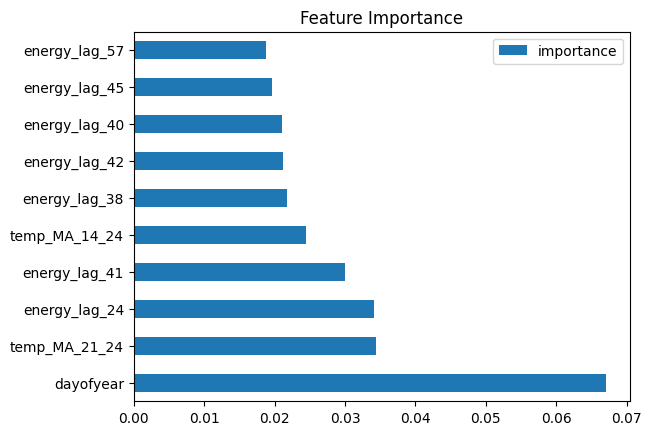

In [ ]:
# top 10 most important features

fe.sort_values('importance', ascending=False).head(10).plot(kind='barh', title='Feature Importance')

# Predictions on the test set

In [ ]:
# Add predicted values to the test DataFrame
test_24['prediction'] = reg.predict(X_test)

/tmp/ipython-input-144-2187107841.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_24['prediction'] = reg.predict(X_test)
/tmp/ipython-input-144-2187107841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_24['prediction'] = reg.predict(X_test)


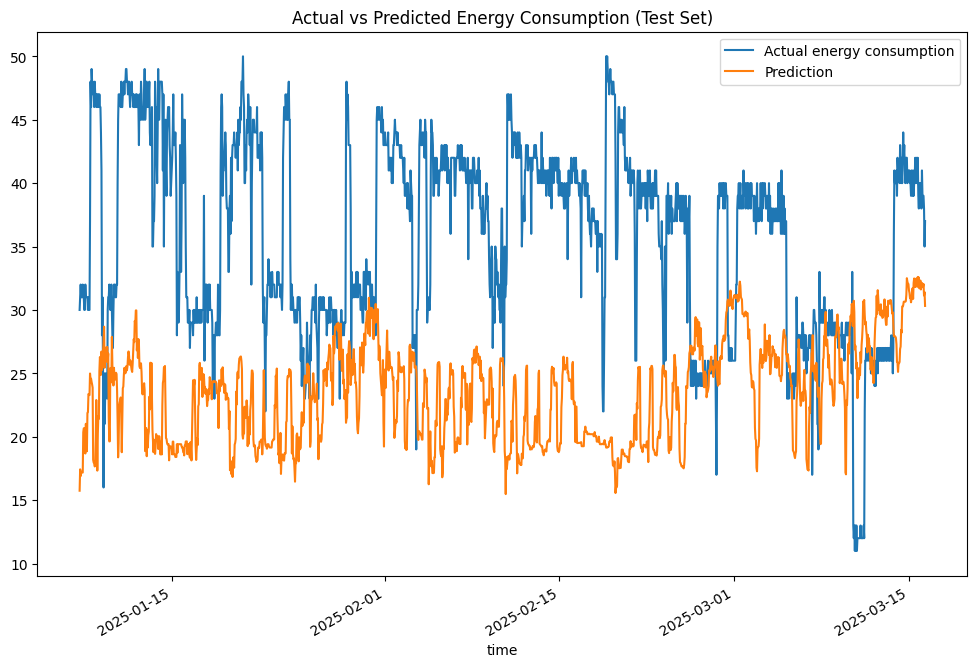

In [ ]:
# Plot actual vs predicted energy consumption on the test dataset

ax = test_24[['energy', 'prediction']].plot(figsize=(12, 8))
plt.legend(['Actual energy consumption', 'Prediction'])
ax.set_title('Actual vs Predicted Energy Consumption (Test Set)')
plt.show()

# Prediction is highly inaccurate.

# Multistep forecast with LSTM

In [ ]:
df_raw

temp  energy
time                             
2024-03-16 09:00:00   9.1    26.0
2024-03-16 10:00:00  11.6    26.0
2024-03-16 11:00:00  13.3    26.0
2024-03-16 12:00:00  14.3    25.0
2024-03-16 13:00:00  15.1    25.0
...                   ...     ...
2025-03-16 03:00:00   1.5    39.0
2025-03-16 04:00:00   1.3    39.0
2025-03-16 05:00:00   0.9    38.0
2025-03-16 06:00:00   0.8    35.0
2025-03-16 07:00:00   0.9    37.0

[8097 rows x 2 columns]

In [ ]:
df_r = df_raw.filter(['energy'])
df_r

energy
time                       
2024-03-16 09:00:00    26.0
2024-03-16 10:00:00    26.0
2024-03-16 11:00:00    26.0
2024-03-16 12:00:00    25.0
2024-03-16 13:00:00    25.0
...                     ...
2025-03-16 03:00:00    39.0
2025-03-16 04:00:00    39.0
2025-03-16 05:00:00    38.0
2025-03-16 06:00:00    35.0
2025-03-16 07:00:00    37.0

[8097 rows x 1 columns]

In [ ]:
# Convert the dataframe to a numpy array
dataset = df_r.values

In [ ]:
# Create X and y sets

history_steps = 72
forecast_steps = 4

X = []
y = []

for i in range(history_steps, len(dataset) - forecast_steps, forecast_steps):
    X.append(dataset[i-history_steps:i, 0])
    y.append(dataset[i:i + forecast_steps, 0])
    if i <= 721:
        print(X)
        print(y)

X = np.array(X)
y = np.array(y)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
       14., 15., 15., 14., 15., 14., 15., 15., 23., 28., 28., 29., 28.,
       30., 28., 28., 29., 29., 28., 28.]), array([14., 15., 14., 15., 15., 15., 14., 14., 14., 15., 15., 14., 15.,
       14., 15., 14., 14., 15., 14., 15., 14., 14., 14., 14., 15., 15.,
       14., 15., 15., 14., 15., 14., 14., 15., 14., 15., 14., 14., 15.,
       14., 15., 14., 15., 14., 14., 15., 14., 15., 14., 15., 15., 14.,
       15., 14., 15., 15., 23., 28., 28., 29., 28., 30., 28., 28., 29.,
       29., 28., 28., 29., 29., 29., 28.]), array([15., 15., 14., 14., 14., 15., 15., 14., 15., 14., 15., 14., 14.,
       15., 14., 15., 14., 14., 14., 14., 15., 15., 14., 15., 15., 14.,
       15., 14., 14., 15., 14., 15., 14., 14., 15., 14., 15., 14., 15.,
       14., 14., 15., 14., 15., 14., 15., 15., 14., 15., 14., 15., 15.,
       23., 28., 28., 29., 28., 30., 28., 28., 29., 29., 28., 28., 29.,
       29., 29., 28., 30., 27., 29., 29.]), array([14.,

In [ ]:
# Splitting the dataset - part I
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False, random_state=42)

In [ ]:
# Splitting the dataset - part II
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)

In [ ]:
# Scaling the data - part I
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# Scaling the data - part II
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(np.array(y_train))
y_val_scaled   = y_scaler.transform(np.array(y_val))
y_test_scaled  = y_scaler.transform(np.array(y_test))

In [ ]:
# Convert the X_train and y_train to numpy array
X_train_scaled, y_train_scaled = np.array(X_train_scaled), np.array(y_train_scaled)

In [ ]:
# Reshape the data for the modeling
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_train_scaled.shape

(1203, 72, 1)

In [ ]:
# Build the LSTM model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(4)
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [158]:
# Train the model
model.fit(X_train_scaled, y_train_scaled, batch_size=1, epochs=10)

Epoch 1/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - loss: 0.0200
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - loss: 0.0097
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - loss: 0.0085
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 139s 67ms/step - loss: 0.0080
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - loss: 0.0087
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - loss: 0.0083
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - loss: 0.0080
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - loss: 0.0084
Epoch 9/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 143s 69ms/step - loss: 0.0092
Epoch 10/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - loss: 0.0076


In [159]:
# Evaluation on the validation test
y_val_pred = model.predict(X_val_scaled)
y_val_true = y_scaler.inverse_transform(y_val_scaled)
y_val_pred_inv = y_scaler.inverse_transform(y_val_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [160]:
y_val_pred_inv

array([[27.272606, 27.12955 , 26.001875, 25.946526],
       [18.369734, 18.541782, 18.668133, 19.505966],
       [19.548985, 19.560984, 19.383417, 19.99041 ],
       ...,
       [31.19831 , 31.126837, 29.543446, 28.609325],
       [31.423195, 31.286783, 29.812962, 28.929558],
       [31.678057, 31.525887, 30.086157, 29.232956]], dtype=float32)

In [161]:
# Check for accuracy metrics
mse  = mean_squared_error(y_val_true, y_val_pred_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val_true, y_val_pred_inv)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

RMSE: 4.3757, MAE: 2.7977


In [162]:
plt.figure(figsize=(12, 8))

indices4 = np.arange(0, len(y_val_true), 4)

for i in range(0, len(y_val_true), 4):
    plt.plot(indices4, y_val_true[indices4],'o-', label='Real' if i == 0 else "", color='blue', alpha=0.3)
    plt.plot(indices4, y_val_pred_inv[indices4], 's--', label='Pred' if i == 0 else "", color='orange', alpha=0.3)

plt.title("Every 4h prediction of 4h ahead")
plt.xlabel("Hour")
plt.ylabel("=Energy usage")
plt.legend()
plt.grid(True)
plt.show()

In [163]:
# Saving the model

model.save("best_lstm.h5")

In [164]:
# Loading the saved model and checking for accuracy metrics on the test data
#importing
from tensorflow.keras.models import load_model

#loading
final_model = load_model('best_lstm.h5')

#predicting (scaled values)
y_pred_scaled = final_model.predict(X_test_scaled)

#reversing the scaling for y
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_scaled)

#final metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
RMSE: 4.2987, Test MAE: 2.9877


In [165]:
plt.figure(figsize=(12, 8))

indices6 = np.arange(0, len(y_true), 6)

for i in range(0, len(y_true), 6):
    plt.plot(indices6, y_true[indices6],'o-', label='Real' if i == 0 else "", color='blue', alpha=0.3)
    plt.plot(indices6, y_pred[indices6], 's--', label='Pred' if i == 0 else "", color='orange', alpha=0.3)

plt.title("Every 4h prediction of 4h ahead")
plt.xlabel("Hour")
plt.ylabel("=Energy usage")
plt.legend()
plt.grid(True)
plt.show()

The LSTM model gives accurate predictions - RMSE ca. 4.3, MAE ca. 3.0. The chart above also shows that predictions are pretty much aligned with real values. However, further improvement of the model could give more precise results in  terms of accuracy of predictions. Predction of few (4) hours ahead is possible with high accuracy and it should result in ability of correcting the heat geenration of usage to avoid any energy production losses.